## Problem-statement

#### In this notebook, our problem-statement is to analyse S&P500 stock prices (We will analyze 10 popular stocks and
#### forecast the future prices) and build forecasting models that beat the market.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from scipy import stats
import matplotlib.dates as mdates
from plotly import tools
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

init_notebook_mode(connected=True)
%matplotlib inline
# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
import warnings
warnings.filterwarnings("ignore")


In [12]:
import mplfinance as mpf

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

In [13]:
# Read the dataframe
df = pd.read_csv("all_stocks_5yr.csv")

In [14]:
df.head().style.set_properties(**{'background-color': 'black',
                                               'color': 'lawngreen',
                                               'border': '1.5px  white'})

In [15]:
def information_func(df):
    # Unique stocks
    unique_stocks = df['Name'].nunique()
    print(f"Unique stocks available in dataset: {unique_stocks}")
    print("----" * 20)
    
    # Metadata of dataset
    print("Metadata of the dataset:\n")
    df.info()
    print("----" * 20)
    
    # Missing values
    null_values = df.isnull().sum()
    print("Missing values in each column:\n", null_values)
    print("----" * 20)
    
    # Maximum range of stocks dataset
    delta = (pd.to_datetime(df['date']).max() - pd.to_datetime(df['date']).min())
    print(f"Time range of stocks dataset: {delta}")
    print("----" * 20)



# Call the function
information_func(df)


Unique stocks available in dataset: 505
--------------------------------------------------------------------------------
Metadata of the dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB
--------------------------------------------------------------------------------
Missing values in each column:
 date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64
--------------------------------------------------------------------------------
Time range of stocks dataset: 1825 days 

<div style="background-color: #4bd659; color: black; padding: 10px;">
    <h1>Data Cleaning</h1>
</div>


In [16]:
# Rename 'Name' to 'ticks'
rdf = df.rename(columns={'Name': 'ticks'})

# Drop rows with null values as they are few and won't affect the time series
rdf.dropna(inplace=True)

# Change the dtype of 'date' column
new_df = rdf.copy()
new_df['date'] = pd.to_datetime(rdf['date'], format='%Y-%m-%d')

# Display the new dataframe info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   ticks   619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


<div style="background-color: #4bd659; color: black; padding: 10px;">
    <h1>Top 10 Stock Tickers by Average Trade Volume</h1>
</div>


In [18]:
# Create an empty dictionary to store the average trade volume for each stock
mean_dict = {}

# Calculate the average trade volume for each stock ticker using a for loop
for key in new_df['ticks'].unique():
    value = new_df[new_df['ticks'] == key]['volume'].mean()
    mean_dict[key] = value

print("Length of the mean of ticks dictionary:", len(mean_dict))

# Convert the dictionary to a pandas Series
average_s = pd.Series(mean_dict).transpose()

# Sort the Series to get the top 10 most traded stocks by average trade volume
top10_s = average_s.sort_values(ascending=False)[:10]

print("Top 10 company tickers with highest average traded stock volume:\n", top10_s.index)


Length of the mean of ticks dictionary: 505
Top 10 company tickers with highest average traded stock volume:
 Index(['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO'], dtype='object')


In [19]:
# function to return top 10 sub dataframe
def subdataframe(df, tick):
    
    # top 10 ticks
    ticks = list(top10_s.index)
    
    assert tick in ticks, """Stock tick does not belong to top 10 stocks by trade volume, please try any of these:\n
    ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']"""
    
    ndf = new_df[new_df['ticks'] == tick]
    return ndf

In [20]:
# company dict for respective ticks (TOP 10 STOCKS BY AVERAGE TRAE VOLUME)
company_dict = {'BAC':'Bank of America', 
                'AAPL':'Apple', 
                'GE':'General Electric', 
                'F':'Ford Motor Company', 
                'FB':'Facebook', 
                'MSFT':'Microsoft', 
                'AMD':'Adavanced Micro Devices', 
                'MU':'Micron Technology', 
                'INTC':'Intel Corp', 
                'CSCO':'Cisco'
               }

bac_df = subdataframe(new_df, 'BAC')
aapl_df = subdataframe(new_df, 'AAPL')
ge_df = subdataframe(new_df, 'GE')
f_df = subdataframe(new_df, 'F')
fb_df = subdataframe(new_df, 'FB')
msft_df = subdataframe(new_df, 'MSFT')
amd_df = subdataframe(new_df, 'AMD')
mu_df = subdataframe(new_df, 'MU')
intc_df = subdataframe(new_df, 'INTC')
csco_df = subdataframe(new_df, 'CSCO')


# define a function to return daily return and company column
def dailyfunc(df):
    df['daily return'] = ((df['close'] - df['open'])/df['open'])*100
    df.style.format('{:.2f}%', subset='daily return')
    df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low'])/4
    df['co_name'] = company_dict[df['ticks'].unique()[0]]
    return df

bac_df = dailyfunc(bac_df)
aapl_df = dailyfunc(aapl_df)
ge_df = dailyfunc(ge_df)
f_df = dailyfunc(f_df)
fb_df = dailyfunc(fb_df)
msft_df = dailyfunc(msft_df)
amd_df = dailyfunc(amd_df)
mu_df = dailyfunc(mu_df)
intc_df = dailyfunc(intc_df)
csco_df = dailyfunc(csco_df)

print('\t\tStart Date\t\t\t\t\tEnd Date')
print(f"BAC\t\t{bac_df['date'].min()}\t\t\t{bac_df['date'].max()}")
print(f"AAPL\t\t{aapl_df['date'].min()}\t\t\t{aapl_df['date'].max()}")
print(f"GE\t\t{ge_df['date'].min()}\t\t\t{ge_df['date'].max()}")
print(f"F\t\t{f_df['date'].min()}\t\t\t{f_df['date'].max()}")
print(f"FB\t\t{fb_df['date'].min()}\t\t\t{fb_df['date'].max()}")
print(f"MSFT\t\t{msft_df['date'].min()}\t\t\t{msft_df['date'].max()}")
print(f"AMD\t\t{amd_df['date'].min()}\t\t\t{amd_df['date'].max()}")
print(f"MU\t\t{mu_df['date'].min()}\t\t\t{mu_df['date'].max()}")
print(f"INTC\t\t{intc_df['date'].min()}\t\t\t{intc_df['date'].max()}")
print(f"CSCO\t\t{csco_df['date'].min()}\t\t\t{csco_df['date'].max()}")

		Start Date					End Date
BAC		2013-02-08 00:00:00			2018-02-07 00:00:00
AAPL		2013-02-08 00:00:00			2018-02-07 00:00:00
GE		2013-02-08 00:00:00			2018-02-07 00:00:00
F		2013-02-08 00:00:00			2018-02-07 00:00:00
FB		2013-02-08 00:00:00			2018-02-07 00:00:00
MSFT		2013-02-08 00:00:00			2018-02-07 00:00:00
AMD		2013-02-08 00:00:00			2018-02-07 00:00:00
MU		2013-02-08 00:00:00			2018-02-07 00:00:00
INTC		2013-02-08 00:00:00			2018-02-07 00:00:00
CSCO		2013-02-08 00:00:00			2018-02-07 00:00:00


<div style="background-color: #4bd659; color: black; padding: 5px;">
    <h1>Closing stock price visualizations & maximum price during 5 years</h1>
</div>

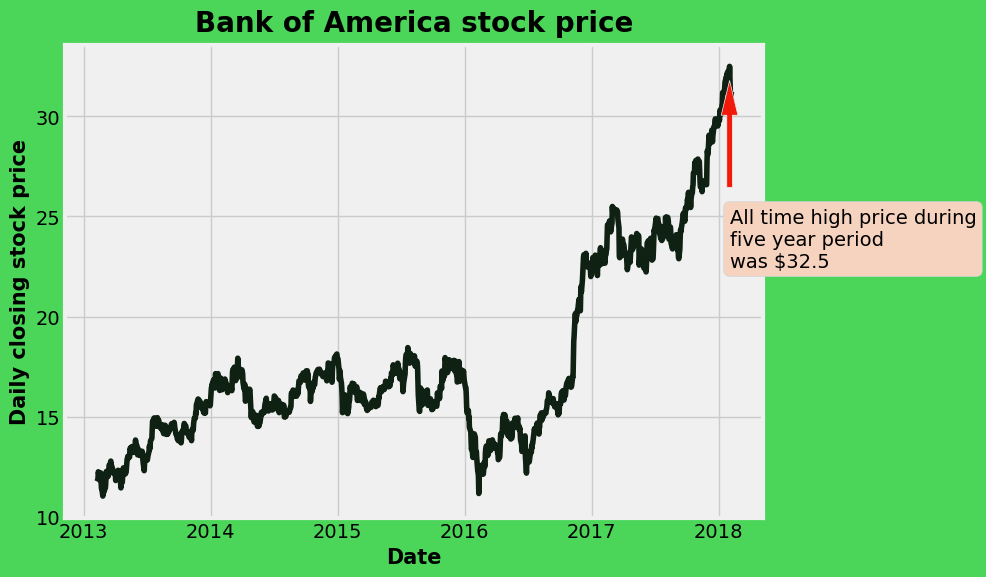

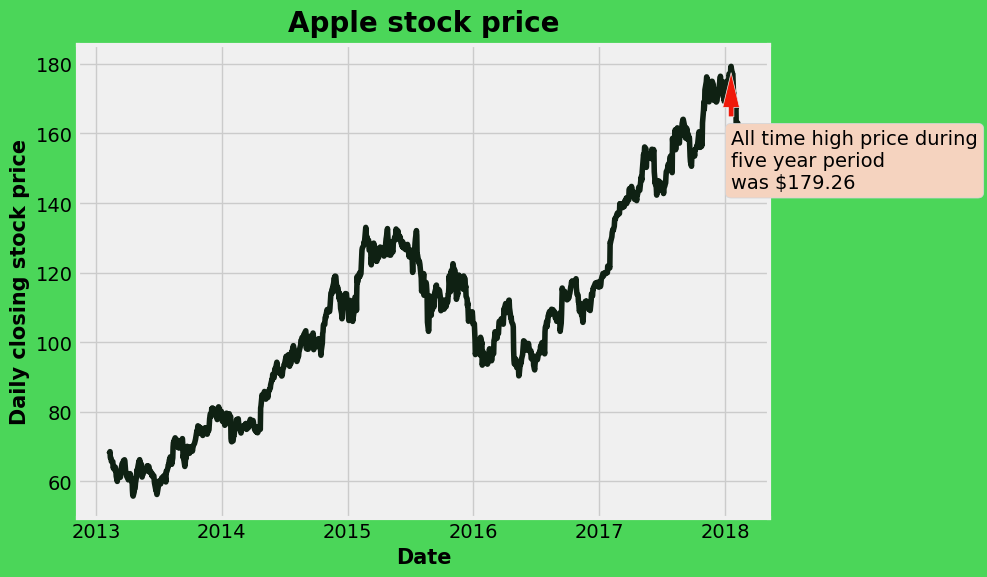

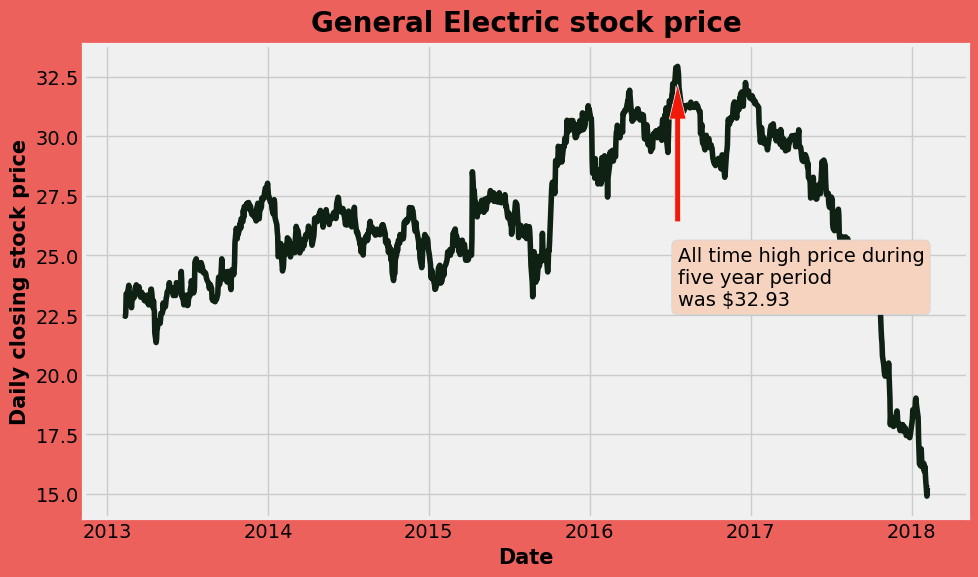

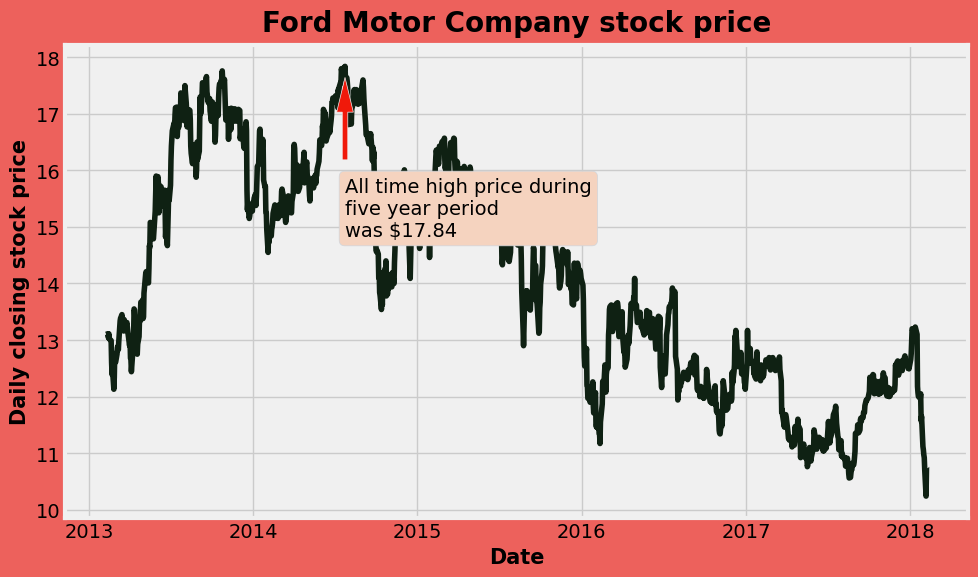

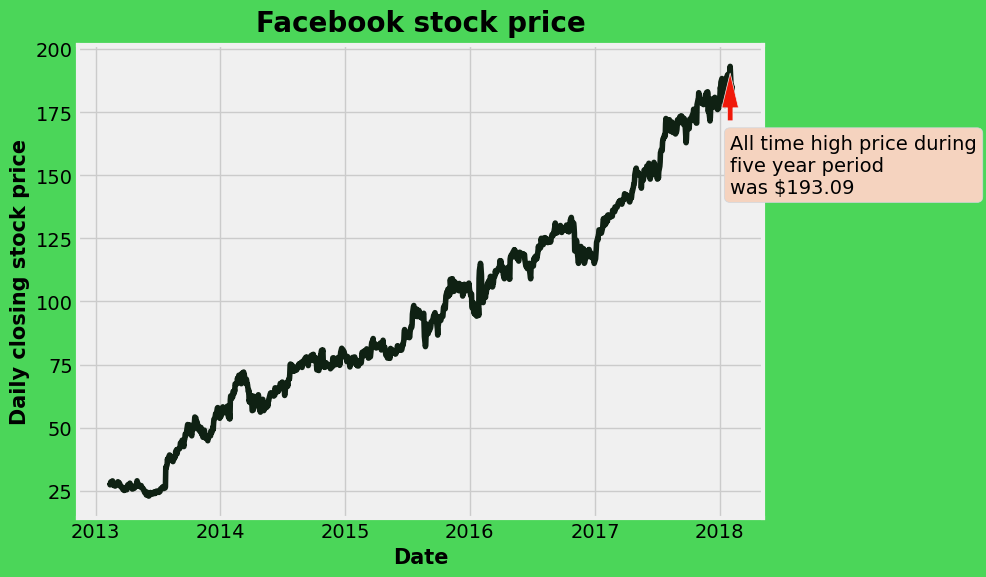

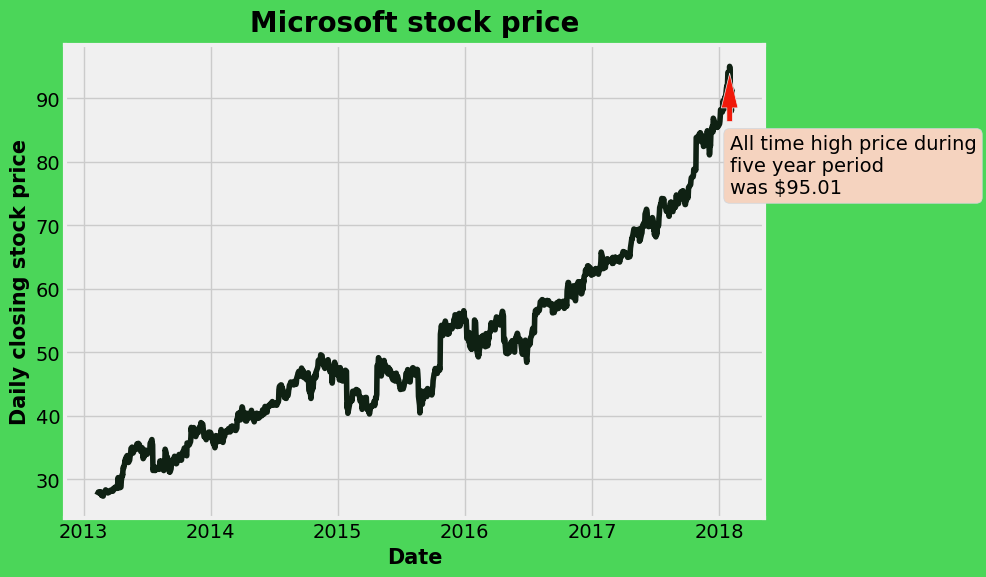

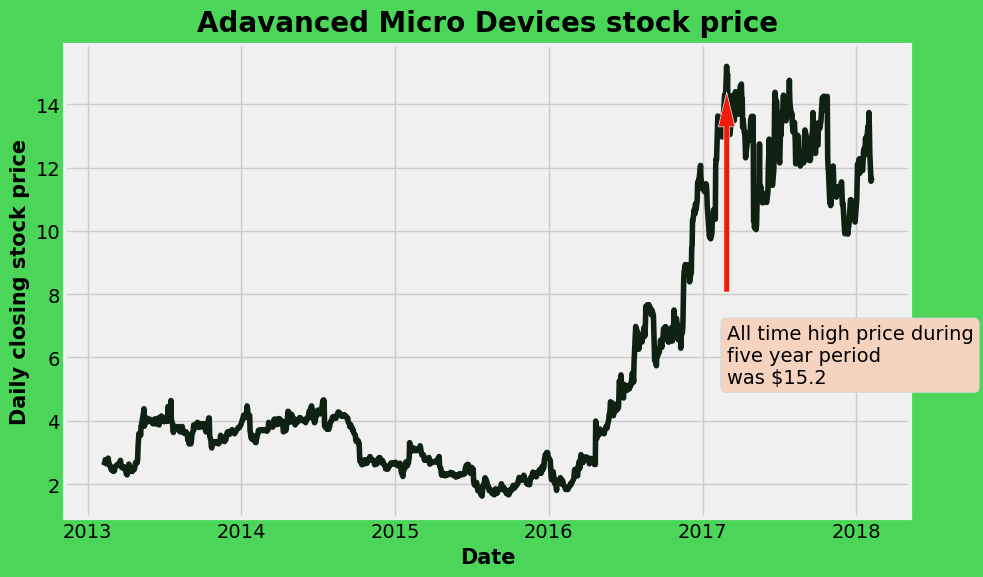

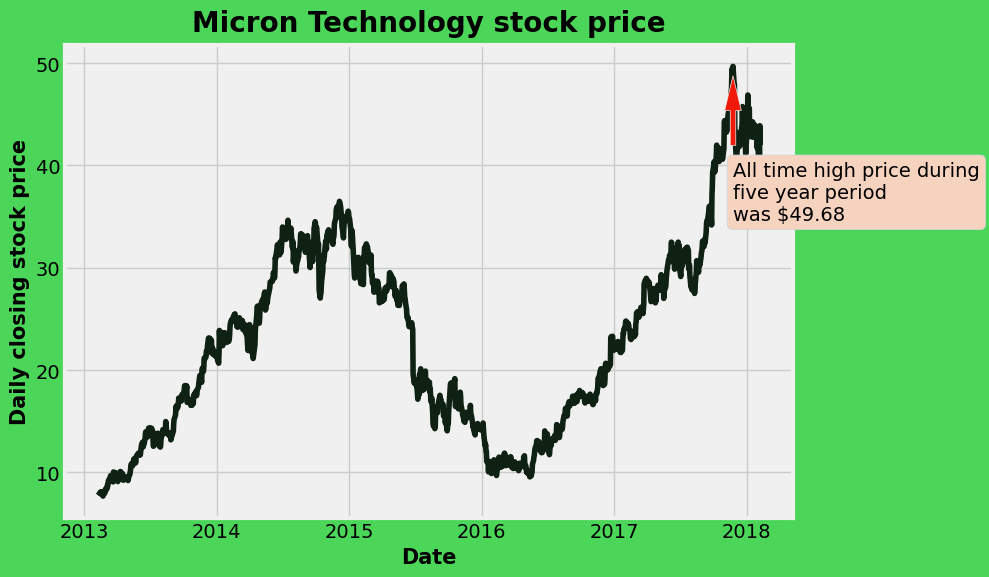

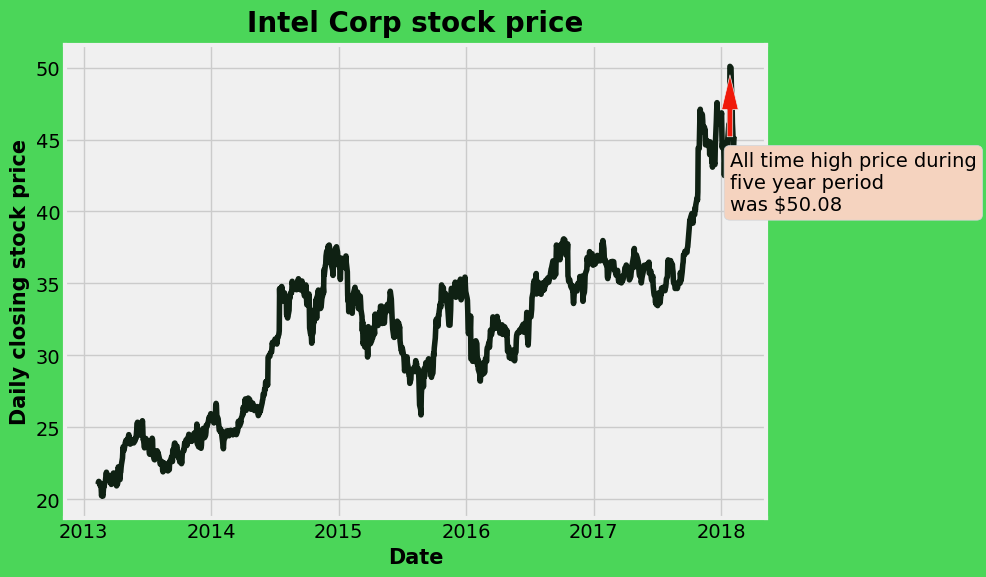

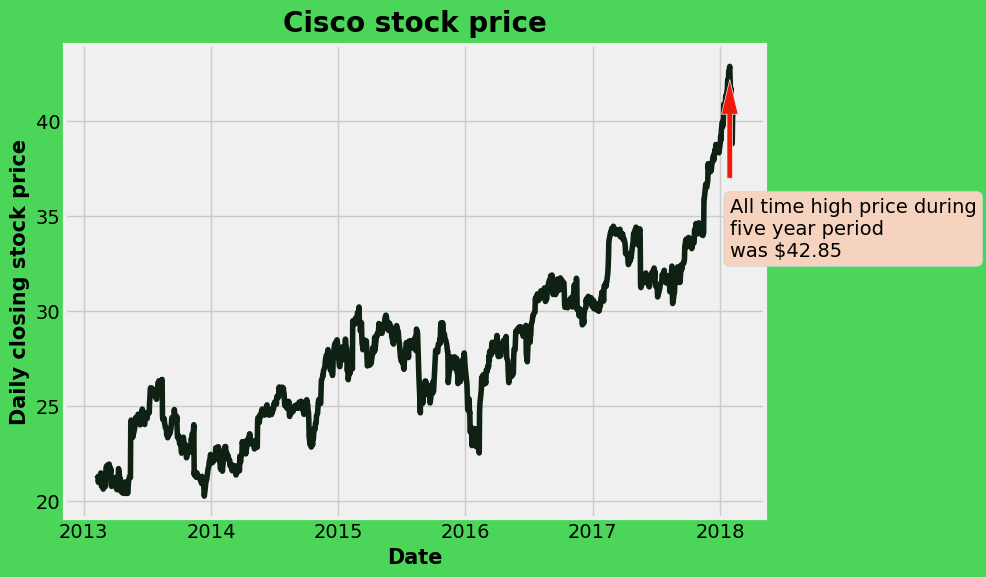

In [21]:
# function return closing stock price over a 5 years of time period
def closing_stock_price(df):
    
    # define highest stock over 5 period of time with date of the same
    high = df['close'].max()
    datetime = df[df['close'] == df['close'].max()]['date'].values
    
    if df['ticks'].unique()[0] == 'GE':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    elif df['ticks'].unique()[0] == 'F':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    else:
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['close'], color='#0f2113')
    ax.set_title(f"{df['co_name'].unique()[0]} stock price", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily closing stock price", fontsize=15)
    if df['ticks'].unique()[0] == 'AAPL':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-35),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'F':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-3),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'FB':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-50),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MSFT':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-20),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MU':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-15),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    else:
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-10),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))

    plt.show()
    
# plot of all the closing stocks
closing_stock_price(bac_df)
closing_stock_price(aapl_df)
closing_stock_price(ge_df)
closing_stock_price(f_df)
closing_stock_price(fb_df)
closing_stock_price(msft_df)
closing_stock_price(amd_df)
closing_stock_price(mu_df)
closing_stock_price(intc_df)
closing_stock_price(csco_df)

## Key findings:

- We could find TOP 10 most traded stocks during the period of 2013-2018.
- Out of 10 companies, one is a bank, 7 of them are tech companies, and the remaining two are non-tech legacy companies, namely General Electric and Ford Motors.
- From the closing stock price visualization, we can observe that stocks 'GE' and 'F' are declining, while other tech stocks are rising over a five-year period.
- The visualizations are self-explanatory and allow us to see the all-time high stock prices of all the tickers.


<div style="background-color: #4bd659; color: black; padding: 5px;">
    <h1>Trade volume of stocks over a period of 2013-2018</h1>
</div>

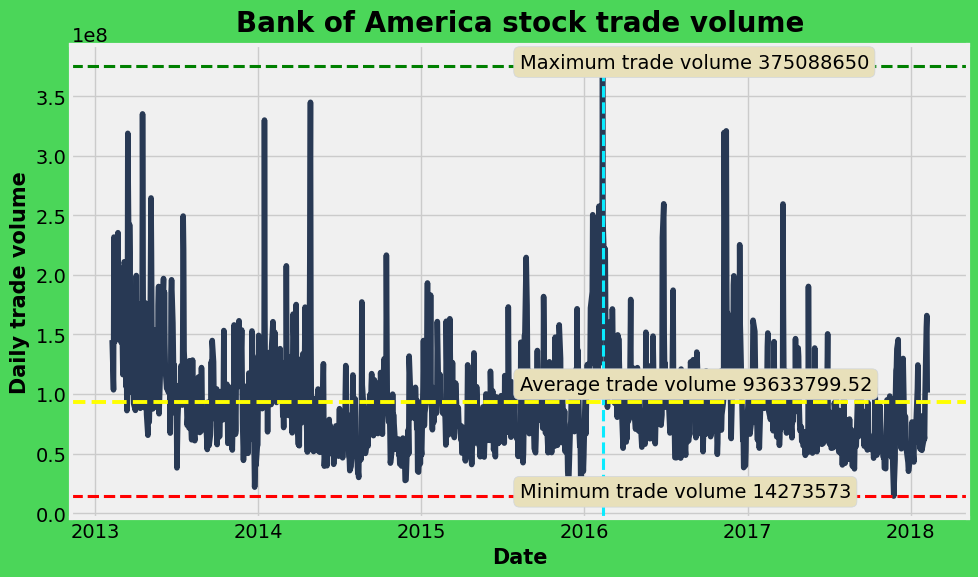

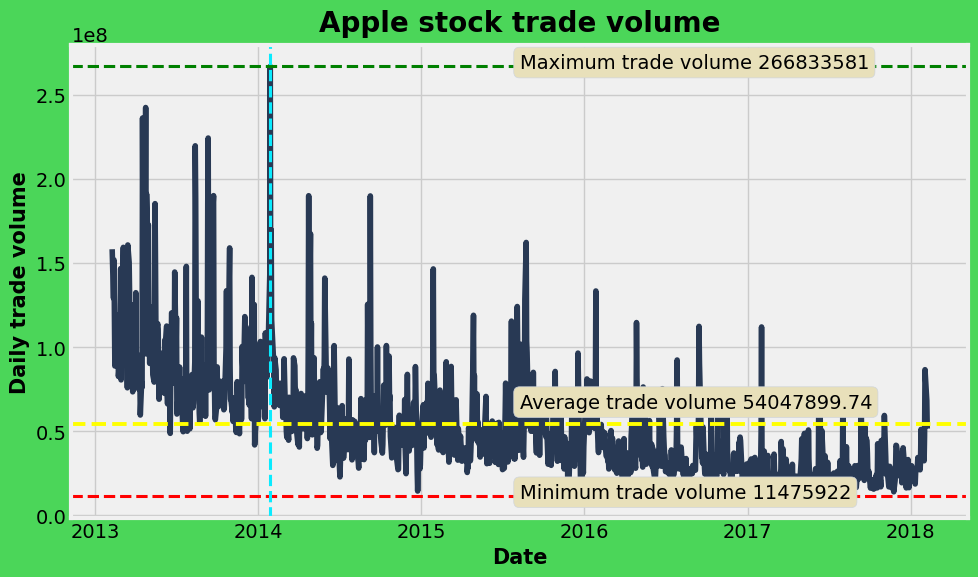

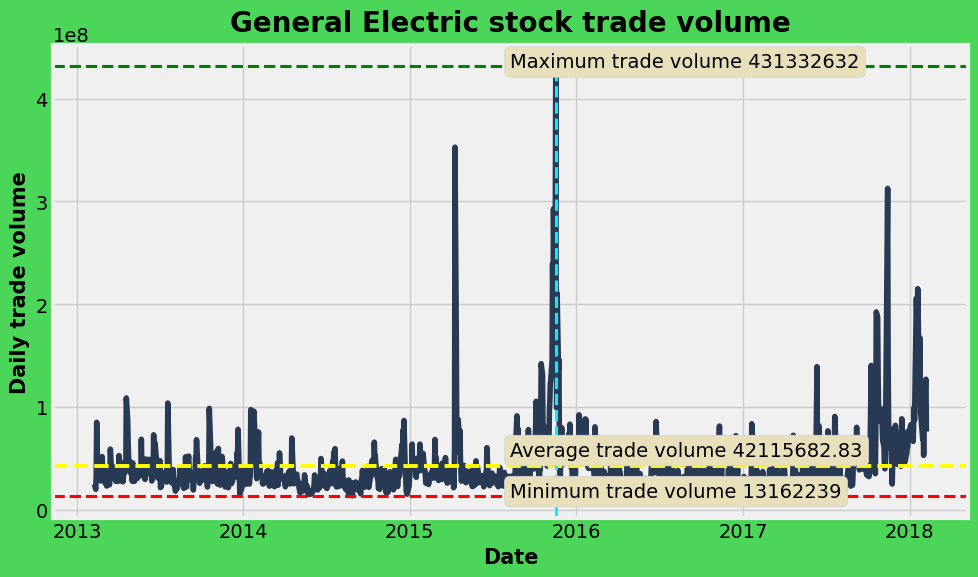

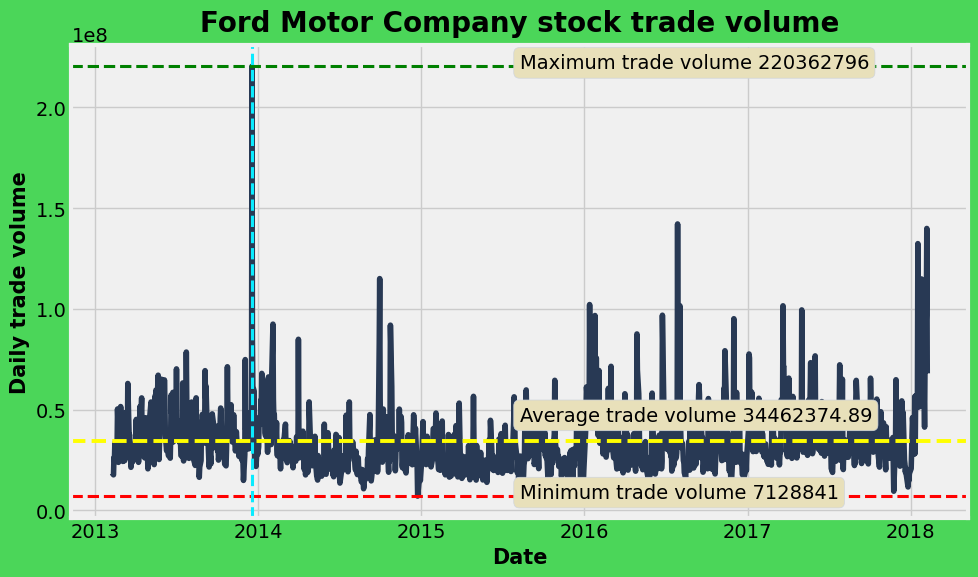

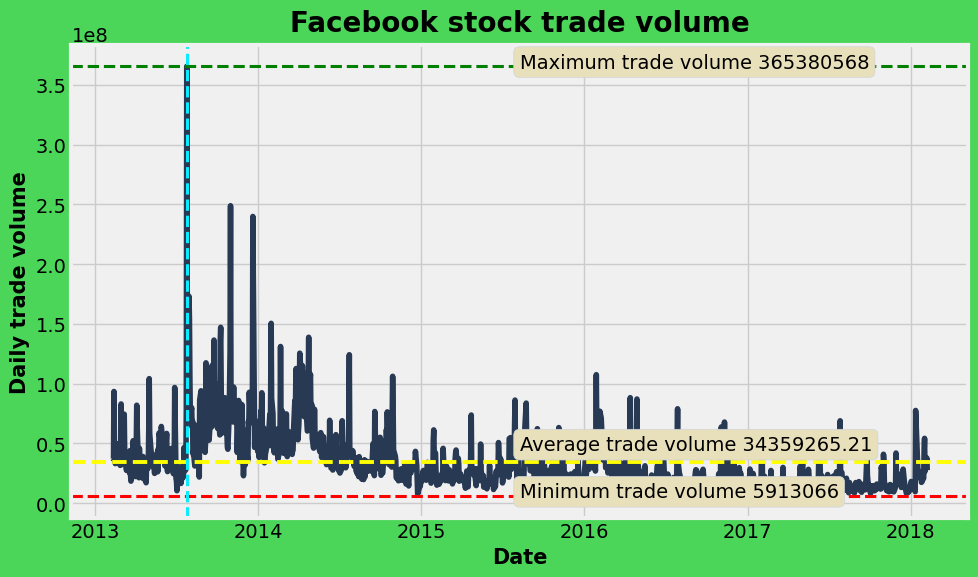

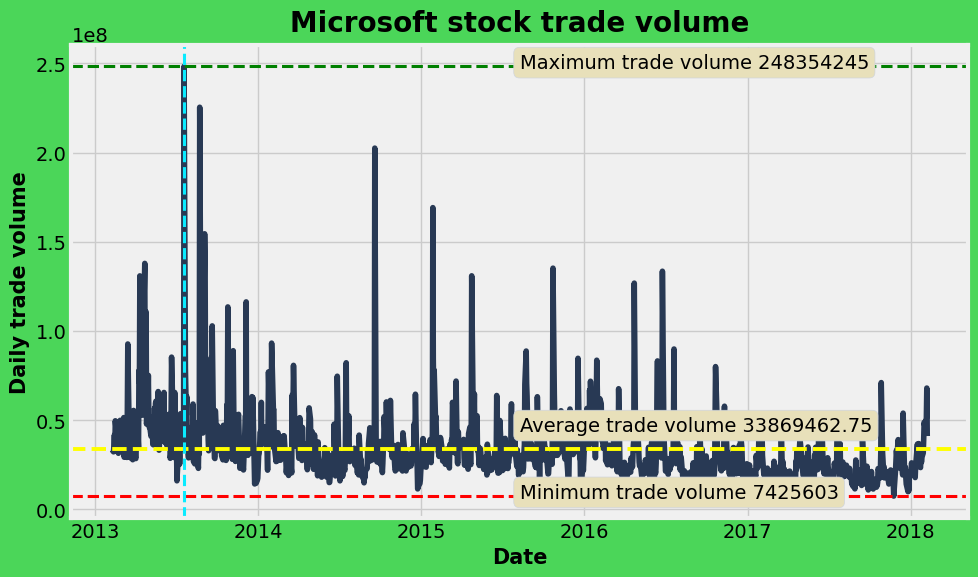

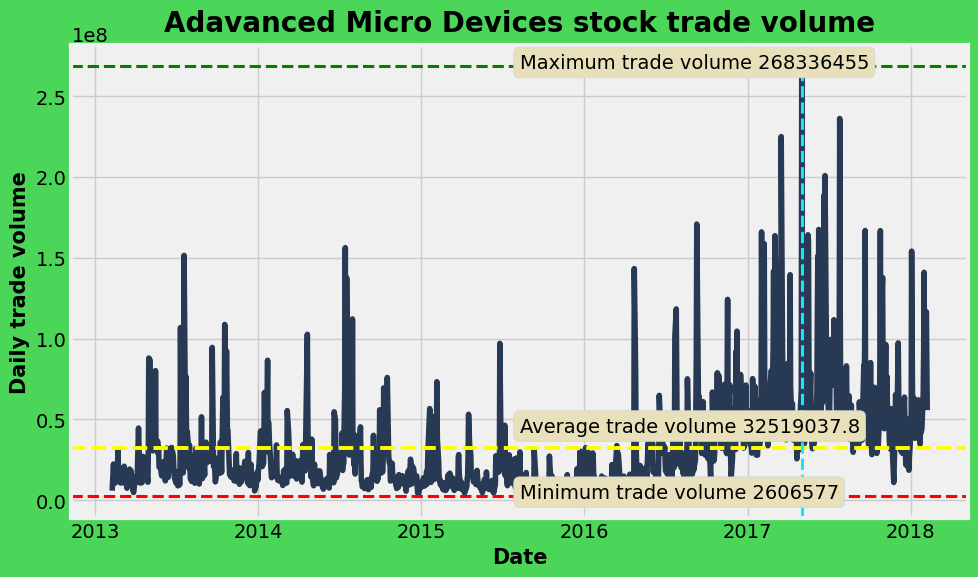

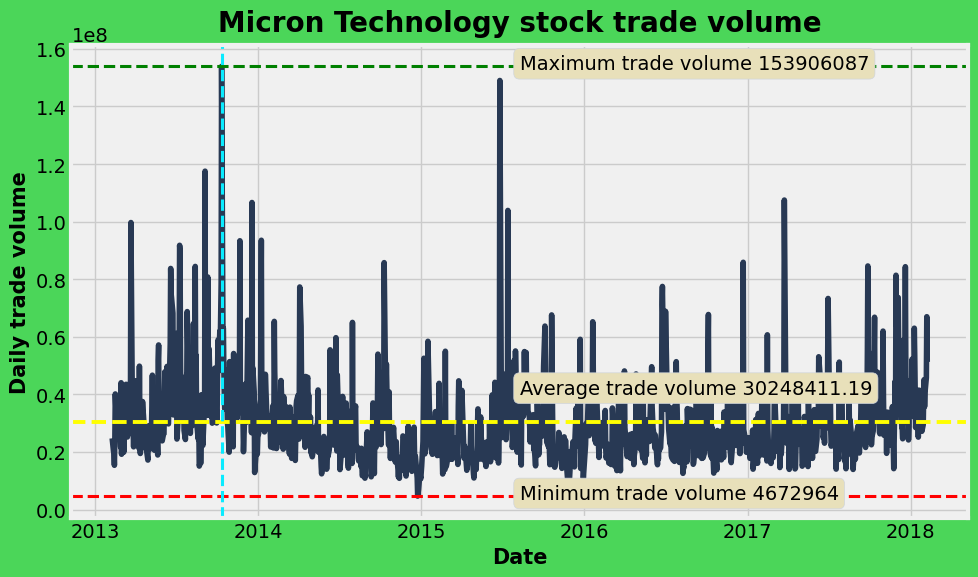

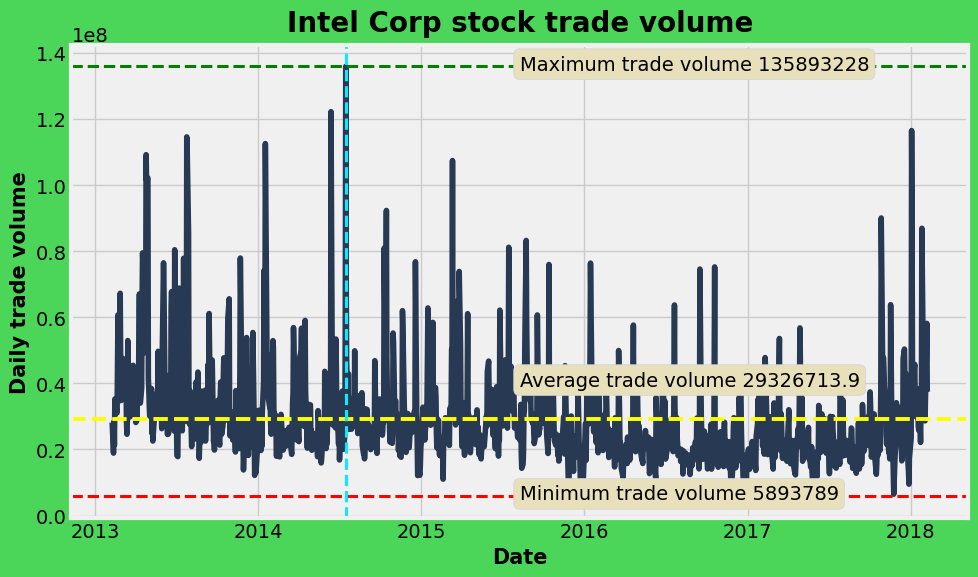

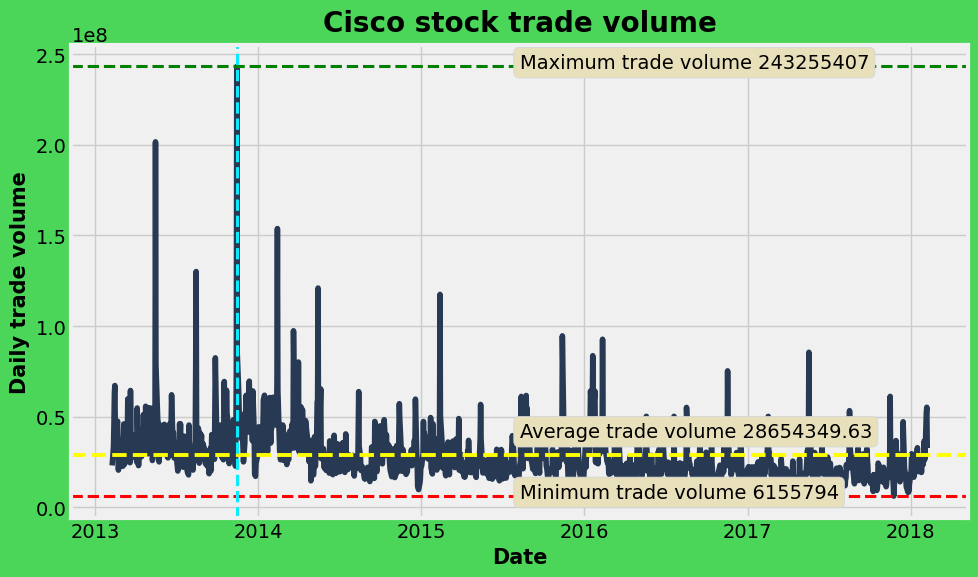

In [22]:
# function to visualize trade volume of stocks
def trade_vol(df):
    
    # x and y coords for average trade volume
    ave_x = df['date'].mean()
    ave_y = df['volume'].mean()
    # y coord for max trade vol
    max_y = df['volume'].max()
    # y coord for min trade vol
    min_y = df['volume'].min()
    
    fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['volume'], color='#283954')
    ax.set_title(f"{df['co_name'].unique()[0]} stock trade volume", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily trade volume", fontsize=15)
    ax.axhline(y=df['volume'].max(), linestyle='--', lw=2.2, color='green')
    ax.axhline(y=df['volume'].min(), linestyle='--',lw=2.2, color='red')
    ax.axhline(y=df['volume'].mean(), linestyle='--',lw=2.8, color='yellow')
    ax.axvline(x=df[df['volume'] == max_y]['date'].values, ls='--', lw='2.2', color='#0aebff')
    ax.annotate(f"Average trade volume {round(df['volume'].mean(),2)}", 
                xy=(ave_x,ave_y),xytext=(ave_x,ave_y + 10000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Maximum trade volume {df['volume'].max()}", 
                xy=(ave_x,max_y),xytext=(ave_x,max_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Minimum trade volume {df['volume'].min()}", 
                xy=(ave_x,min_y),xytext=(ave_x,min_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    
    plt.show()
    

# plot of all stocks trade volume
trade_vol(bac_df)
trade_vol(aapl_df)
trade_vol(ge_df)
trade_vol(f_df)
trade_vol(fb_df)
trade_vol(msft_df)
trade_vol(amd_df)
trade_vol(mu_df)
trade_vol(intc_df)
trade_vol(csco_df)

## Observations:

- The above visualizations depict the maximum, minimum, and average trade volume over the period of 2013-2018.
- As the visualizations are self-explanatory in nature, we can also learn the variance of trade volume. For example, the stock ticker 'INTC' has the highest variance in trade volume compared to other tickers.


<div style="background-color: #4bd659; color: black; padding: 5px;">
    <h1>Comparative analysis of 7 tech stocks</h1>
</div>

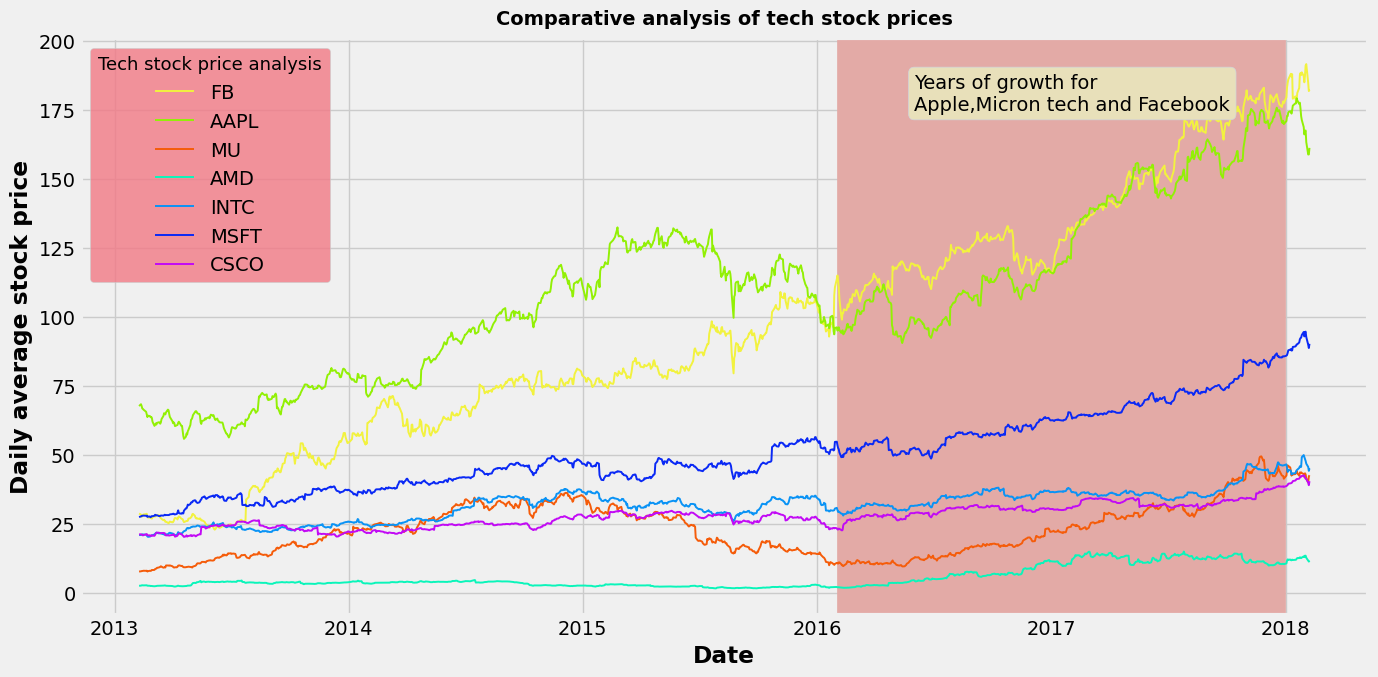

In [23]:
# tech stocks price comparison
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(fb_df['date'], fb_df['daily_mean'],label='FB', color='#f2f23f', lw=1.4)
ax.plot(aapl_df['date'], aapl_df['daily_mean'],label='AAPL', color='#92f005', lw=1.4)
ax.plot(mu_df['date'], mu_df['daily_mean'],label='MU', color='#f55c0a', lw=1.4)
ax.plot(amd_df['date'], amd_df['daily_mean'],label='AMD', color='#0af5ba', lw=1.4)
ax.plot(intc_df['date'], intc_df['daily_mean'],label='INTC', color='#0a93f5', lw=1.4)
ax.plot(msft_df['date'], msft_df['daily_mean'],label='MSFT', color='#0a29f5', lw=1.4)
ax.plot(csco_df['date'], csco_df['daily_mean'],label='CSCO', color='#c20af5', lw=1.4)
ax.axvspan(*mdates.datestr2num(['2/1/2016','12/31/2017']), color='#e3aaa6')
ax.set_title("Comparative analysis of tech stock prices")
ax.annotate("Years of growth for\nApple,Micron tech and Facebook", xy=(mdates.datestr2num('6/1/2016'),175),
           bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'))
ax.set_xlabel("Date")
ax.set_ylabel("Daily average stock price")
ax.legend(facecolor='#f27985', fontsize="medium", title="Tech stock price analysis", title_fontsize=13)

plt.show()

## Observations

- It is very clear that the 'FB' stock was one of the most expensive among all 7 tech stocks.
- The stock ticker 'AMD' was among the cheapest to buy compared to other stocks.
- From the above chart, we can also conclude that stocks like 'FB' and 'AAPL' were also among the most volatile in nature compared to other stocks.


<div style="background-color: #4bd659; color: black; padding: 5px;">
    <h1>Find out growth of stocks of the companies over a 5 years period</h1>
</div>

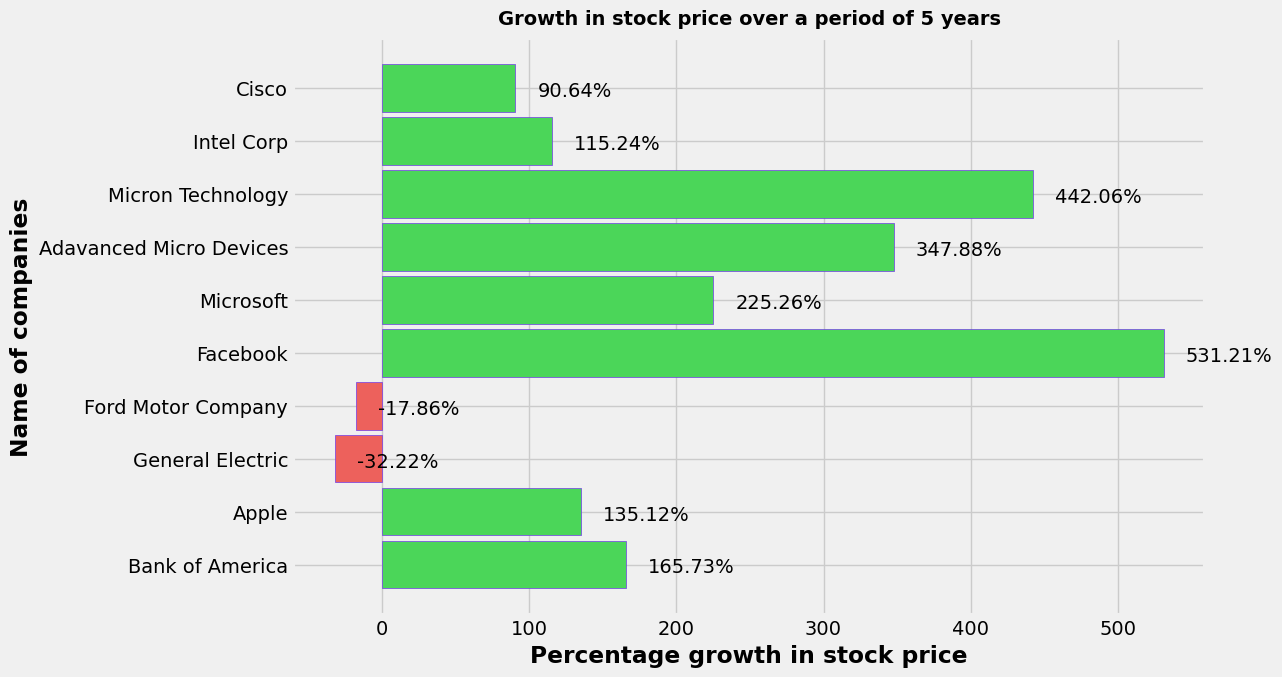

In [24]:
# list of stock dataframes
list_df = [bac_df, aapl_df, ge_df, f_df, fb_df, msft_df, amd_df, mu_df, intc_df, csco_df]

# loop through the the list_df to find mini and maxi of each stocks 
mini = [df[df['date'] == df['date'].min()]['close'].values.item() for df in list_df]
maxi = [df[df['date'] == df['date'].max()]['close'].values.item() for df in list_df]

# find list of abosolute difference between both stock price
diff = np.array(maxi) - np.array(mini)

# find the percentage growth
growth = (diff/mini)*100
growth_list = growth.tolist()
co_name_list = [df['co_name'].unique()[0] for df in list_df]

# visualize the growth of the stocks
fig, ax = plt.subplots(figsize=(13,7))
ax.barh(y=co_name_list, width=growth_list, height=0.9, color=['#4bd659','#4bd659','#ed615c','#ed615c','#4bd659',
                                                             '#4bd659','#4bd659','#4bd659','#4bd659','#4bd659'],
       edgecolor='#713ae8')
for p in ax.patches:
    ax.annotate(f'{round(p.get_width(),2)}%', (p.get_width()+15, p.get_y() +0.3))
ax.set_xlabel('Percentage growth in stock price')
ax.set_ylabel('Name of companies')
ax.set_title("Growth in stock price over a period of 5 years")
plt.show()

## Observations

- We can observe that the growth of the stock 'Facebook' is the highest among all other 10 stocks over a period of 5 years.
- It is evident that stocks of 'Ford Motors' and 'General Electric' have given negative returns over the years.


<div style="background-color: #4bd659; color: black; padding: 5px;">
    <h1>Daily return of stock prices analysis</h1>
</div>

## Daily Return Hypothesis Test

In the stock market, you will often hear that the daily return of any stock price is 0%, which means you will get zero return on your investment in one day. Let's prove this hypothesis by analyzing the top 10 most traded stocks and assessing their daily return distribution in this section.

- **H0 (Null Hypothesis):** Daily return is zero.
- **Ha (Alternative Hypothesis):** Daily return is not zero.

We will perform this hypothesis test as a one-sample t-test, as we know the population mean but are not aware of the standard deviation. If the p-value is greater than 0.05, then we cannot reject the null hypothesis. If it is less than 0.05, then we have to reject the null hypothesis.


In [25]:
# python's scipy.stats module has ttest_1samp method we allows to prove this hypothesis
result_dict = {}
for df in list_df:
    result = stats.ttest_1samp(df['daily return'], 0)
    result_dict[df['ticks'].unique()[0]] = result   
result_dict

{'BAC': Ttest_1sampResult(statistic=-0.3532776176429947, pvalue=0.7239395130534507),
 'AAPL': Ttest_1sampResult(statistic=0.41429430560560776, pvalue=0.6787292124343913),
 'GE': Ttest_1sampResult(statistic=-0.6899014787481074, pvalue=0.4903833915917716),
 'F': Ttest_1sampResult(statistic=-1.829967497402379, pvalue=0.06749132535767648),
 'FB': Ttest_1sampResult(statistic=0.43179923117451596, pvalue=0.6659613318143065),
 'MSFT': Ttest_1sampResult(statistic=2.936864998172622, pvalue=0.00337582087561039),
 'AMD': Ttest_1sampResult(statistic=0.5320769266138293, pvalue=0.5947666691710993),
 'MU': Ttest_1sampResult(statistic=-0.3912233565721498, pvalue=0.6956983959552626),
 'INTC': Ttest_1sampResult(statistic=3.0472693720373076, pvalue=0.002357434011831407),
 'CSCO': Ttest_1sampResult(statistic=2.6892871186777536, pvalue=0.007255138945761972)}

## Interpretation of Results

From the above results, we can learn that the p-values of stocks 'MSFT', 'INTC', and 'CSCO' are less than 0.05. Therefore, we can reject the null hypothesis and accept the alternative hypothesis, which states that 'Daily return is not zero'. However, for the other stocks, we cannot reject the null hypothesis.

Statistically, this suggests that 7 out of 10 stocks have a daily return of zero percentage, which is the most general case.


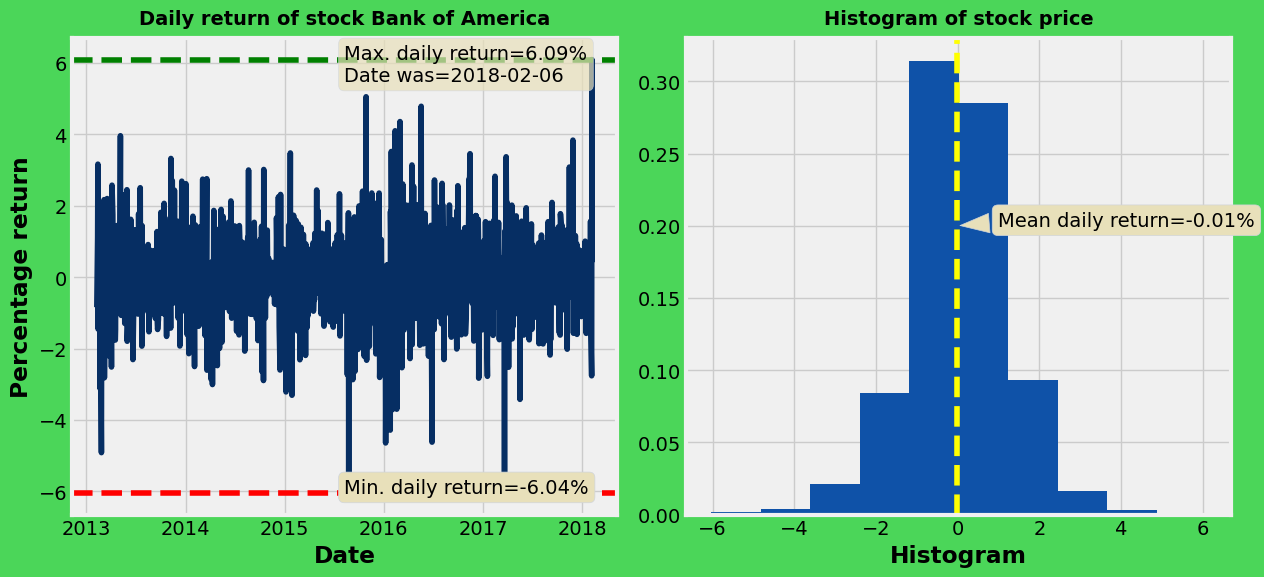

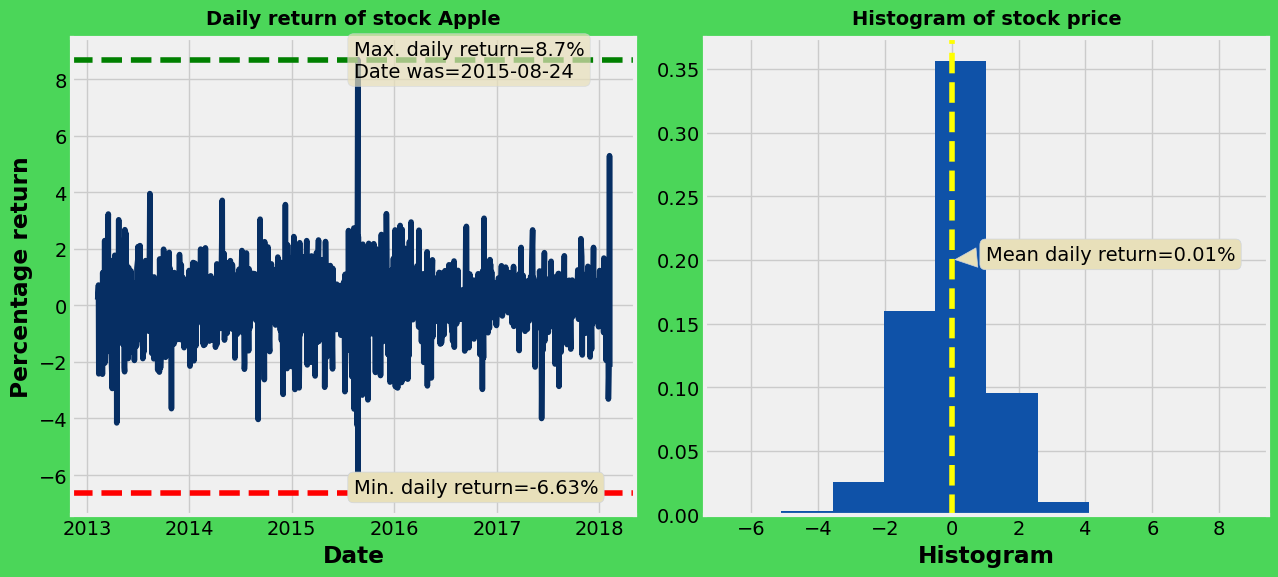

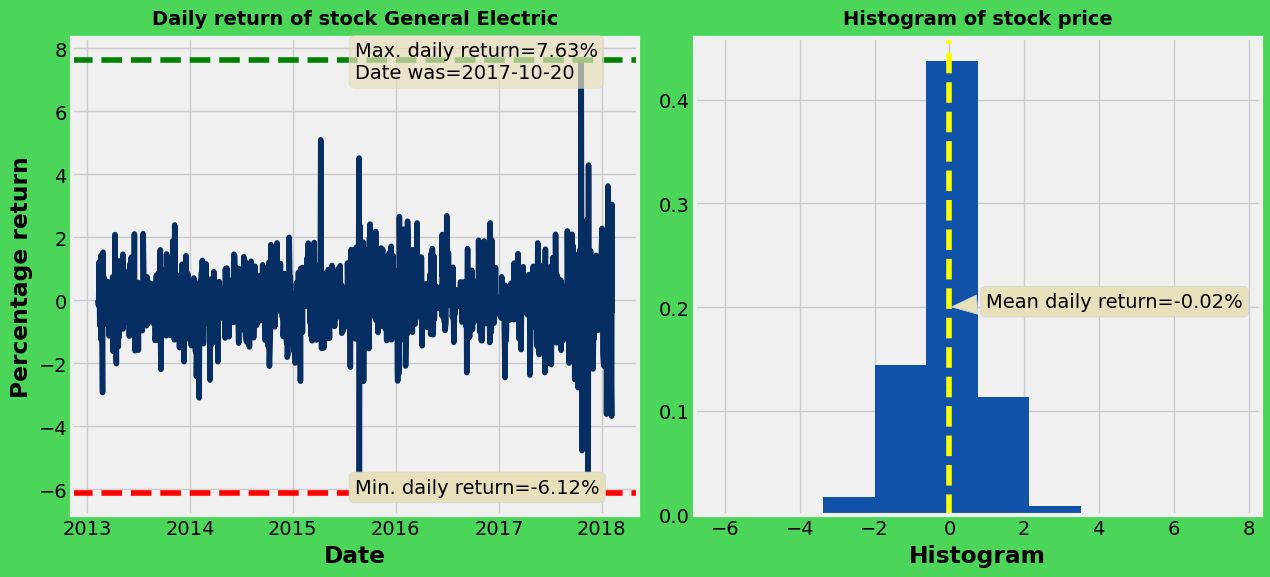

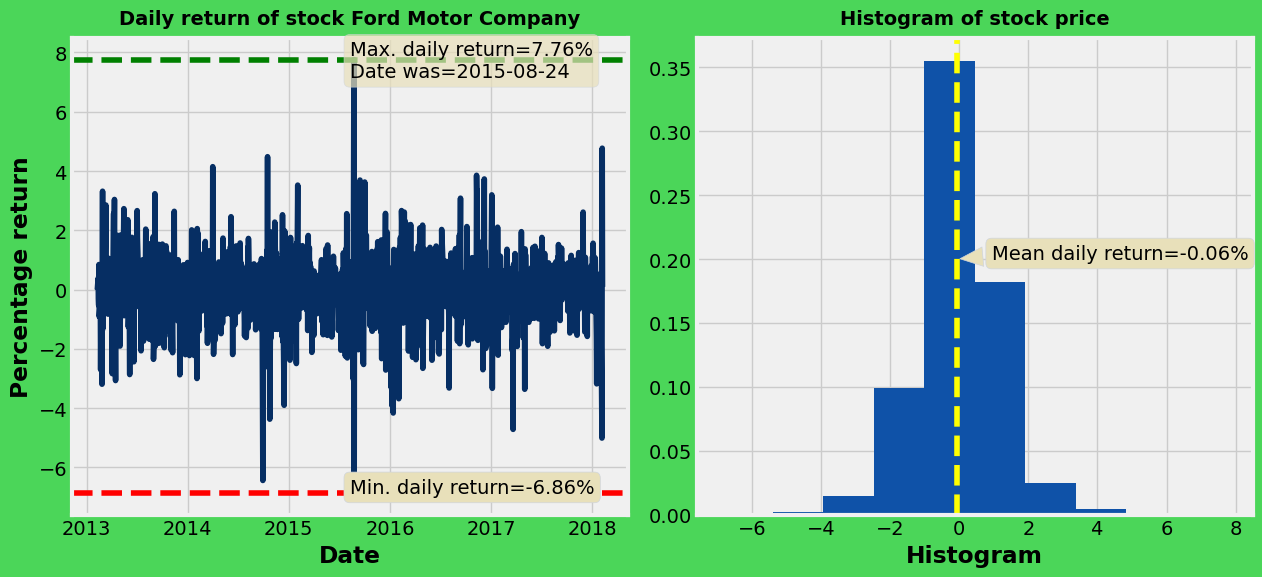

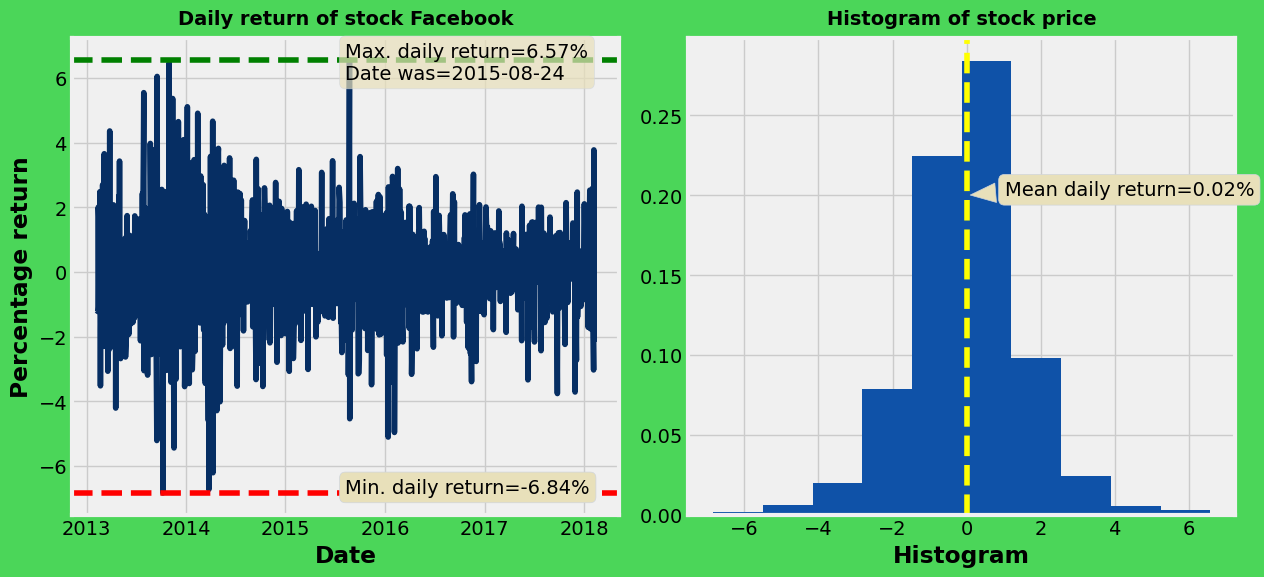

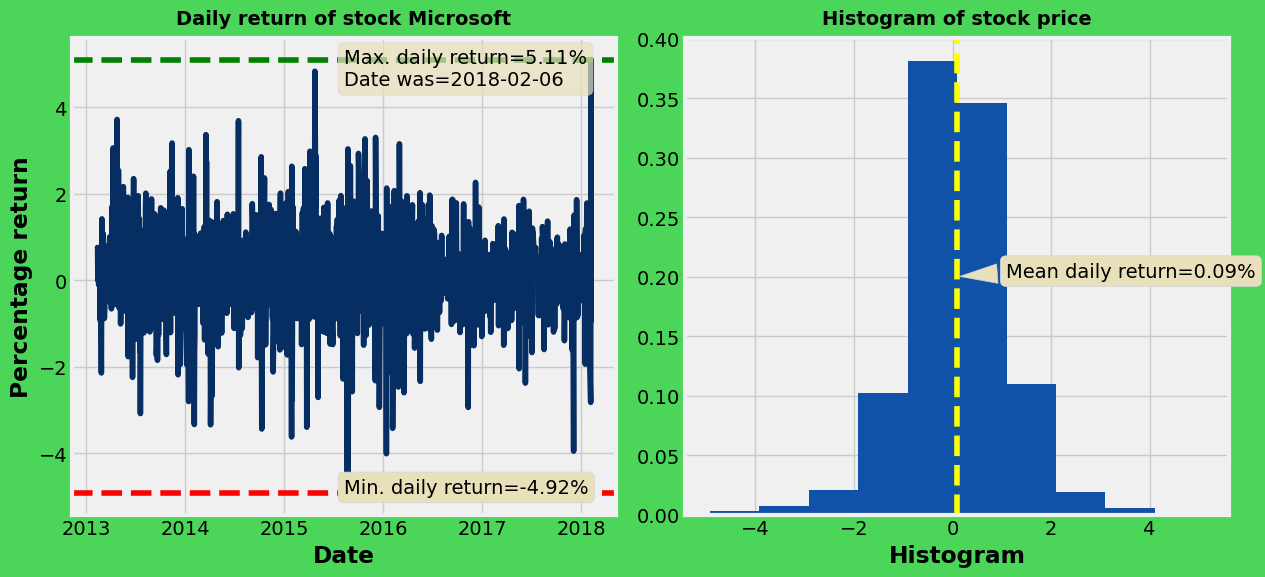

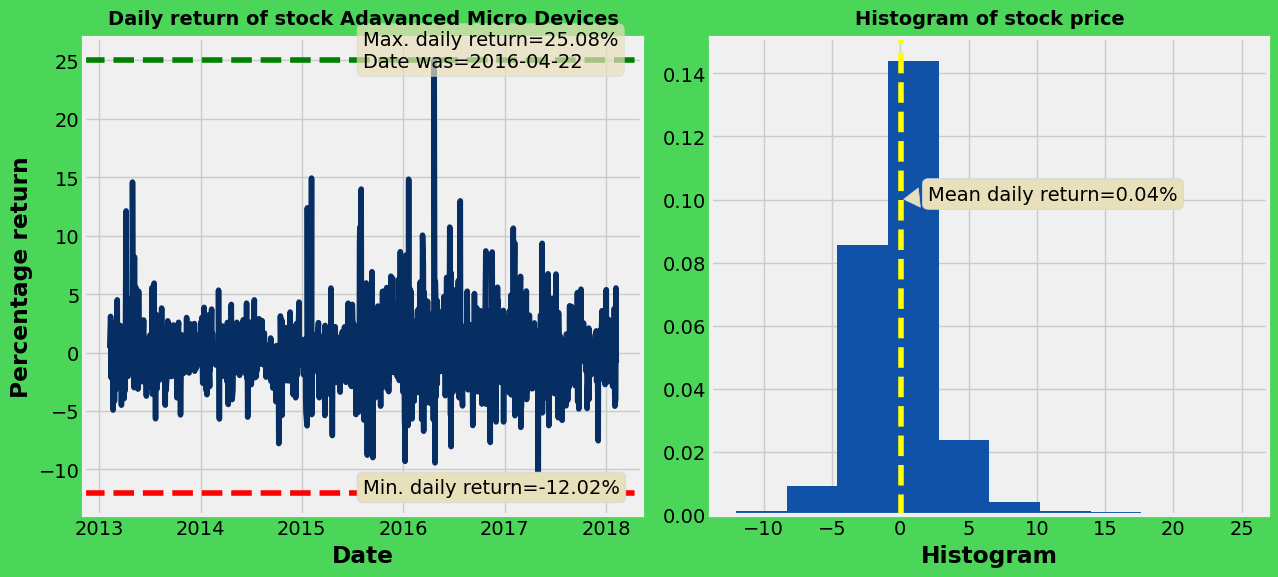

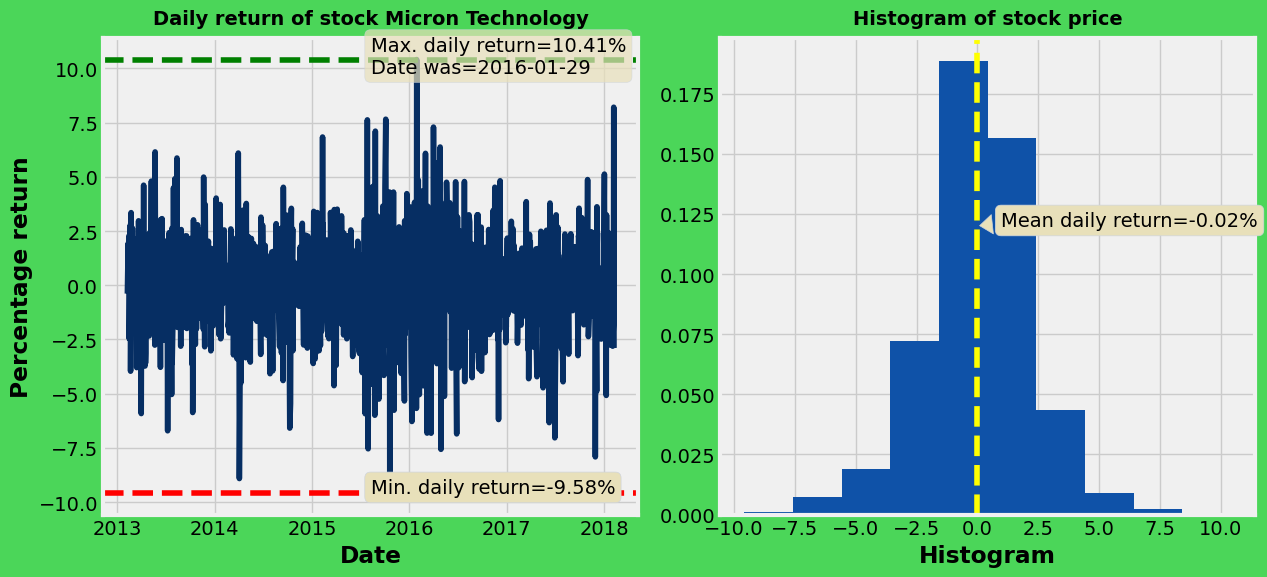

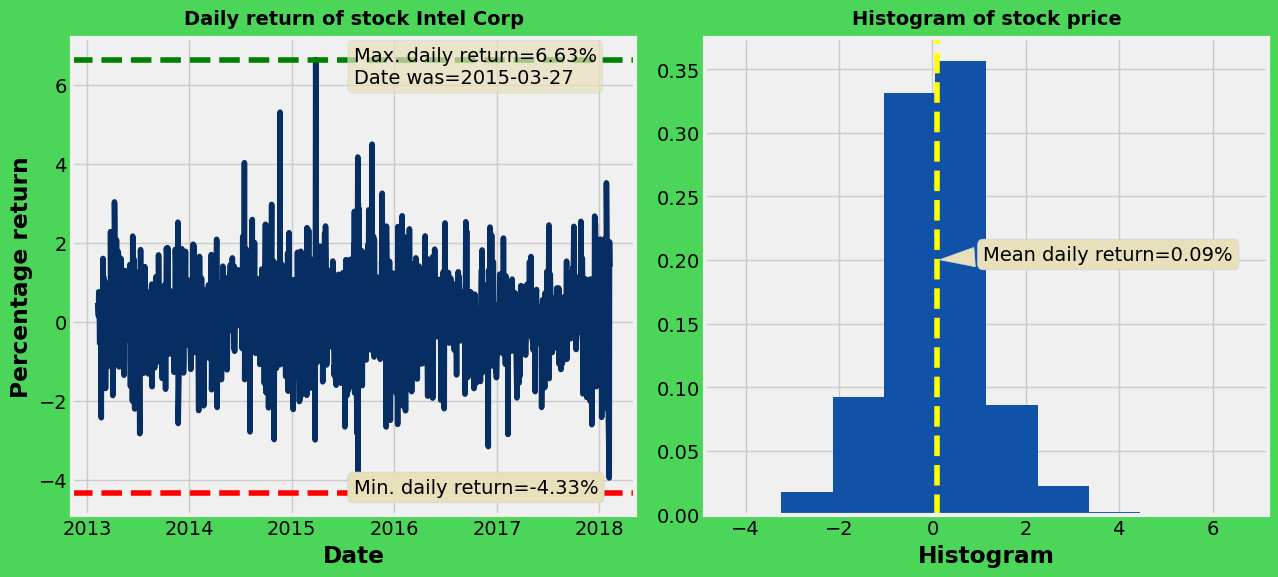

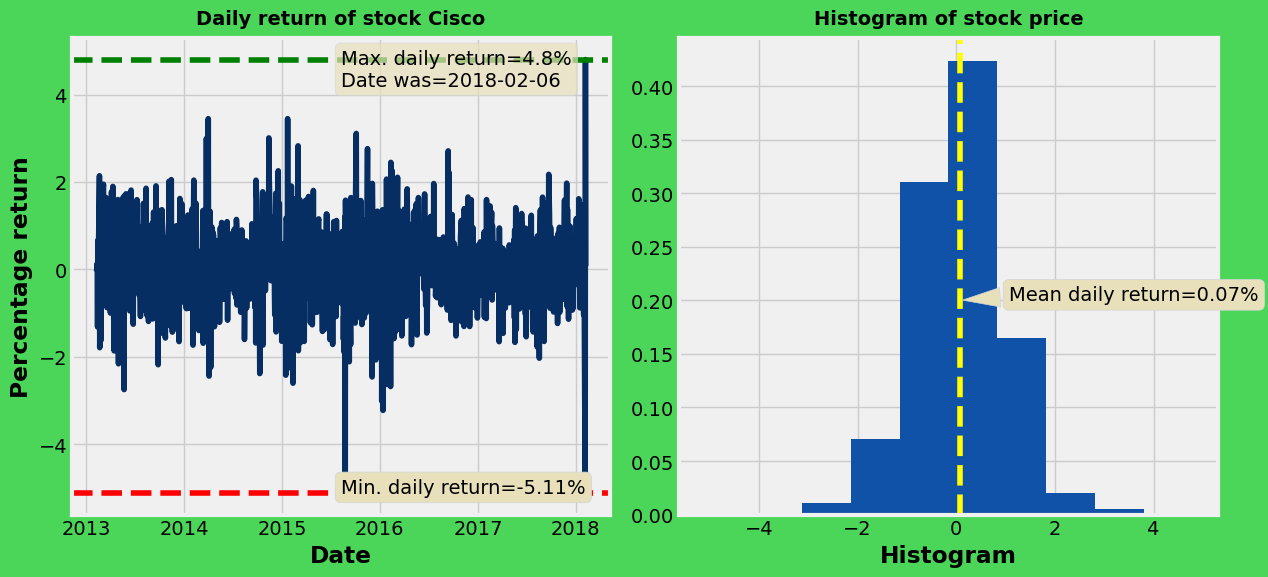

In [26]:
###### function to plot daily return and histogram of 10 stocks
def daily_return(df):
    
    # assign variables to annotation positions
    ave_x = df['date'].mean()
    y_max = df['daily return'].max()
    y_max_date = df[df['daily return'] == df['daily return'].max()]['date'].values
    dt = pd.to_datetime(y_max_date, '%Y%m%d%H%M%S')
    xb = dt.item().date()
    y_min = df['daily return'].min()
    y_mean = df['daily return'].mean()
    
    plt.figure(figsize=(13,6), facecolor='#4bd659')
    
    plt.subplot(121)
    plt.plot(df['date'], df['daily return'], color='#062e63')
    plt.axhline(y=df['daily return'].max(), color='green', ls='--')
    plt.axhline(y=df['daily return'].min(), color='red', ls='--')
    plt.xlabel('Date')
    plt.ylabel("Percentage return")
    plt.annotate(f"Min. daily return={round(df['daily return'].min(),2)}%", 
                xy=(ave_x,y_min),xytext=(ave_x,y_min),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    plt.annotate(f"Max. daily return={round(df['daily return'].max(),2)}%\nDate was={xb}", 
                xy=(ave_x,y_max),xytext=(ave_x,y_max-0.6),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db', alpha=0.7)
                 )
    plt.title(f"Daily return of stock {df['co_name'].unique()[0]}")
    
    plt.subplot(122)
    plt.hist(df['daily return'], density=True, color='#0f52a8')
    plt.xlabel('Histogram')
    plt.axvline(x=df['daily return'].mean(), color='yellow', ls='--')
    if df['ticks'].unique()[0] == 'AMD':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.10),xytext=(y_mean+2,0.10),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    elif df['ticks'].unique()[0] == 'MU':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.12),xytext=(y_mean+1,0.12),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    else:
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.20),xytext=(y_mean+1,0.20),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    plt.title(f"Histogram of stock price")
    
    plt.show()
    
# call the function with dataframe
daily_return(bac_df)
daily_return(aapl_df)
daily_return(ge_df)
daily_return(f_df)
daily_return(fb_df)
daily_return(msft_df)
daily_return(amd_df)
daily_return(mu_df)
daily_return(intc_df)
daily_return(csco_df)

<div style="background-color: #4bd659; color: black; padding: 5px;">
    <h1>Technical analysis of stocks using candle stick charts and moving average</h1>
</div>

In [28]:
# using plotly graph_objs let's plot candlestick charts of stocks
def candlestick_chart(df):
    trace = go.Candlestick(x=df['date'],
                          open=df['open'],
                          high=df['high'],
                          low=df['low'],
                          close=df['close'])
    layout ={
    'title': f"{df['co_name'].unique()[0]} Historical Stock Price",
    'xaxis': {'title': 'Date'
             },
    'yaxis': {'title': 'Stock Price (USD$)'}
}
    
    
    data = [trace]
    
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(xaxis_rangeslider_visible=False, paper_bgcolor='#4bd659')
    fig.show()
    
# plot the charts using this function
candlestick_chart(bac_df)
candlestick_chart(aapl_df)
candlestick_chart(ge_df)
candlestick_chart(f_df)
candlestick_chart(fb_df)
candlestick_chart(msft_df)
candlestick_chart(amd_df)
candlestick_chart(mu_df)
candlestick_chart(intc_df)
candlestick_chart(csco_df)

<div style="background-color: #4bd659; color: black; padding: 5px;">
    <h1>Moving Averages charts of Facebook and Apple</h1>
</div>

## Moving Average of Stocks

- A moving average (MA) is a stock indicator commonly used in technical analysis, used to help smooth out price data by creating a constantly updated average price. A rising moving average indicates that the security is in an uptrend, while a declining moving average indicates a downtrend.

- Moving average is one of the most widely used stock market forecasting methods in the finance industry. In this section, we will plot and analyze the stocks of 'Facebook' and 'Apple' using 10, 50, and 200 days moving averages to identify uptrends and downtrends.


In [29]:
# define function to return copies of stock dataframe with moving averages
def mav_function(df):
    
    # calclulate moving averages of 10,50 and 200 days
    df['10_d_avg'] = df['close'].rolling(window=10).mean()
    df['50_d_avg'] = df['close'].rolling(window=50).mean()
    df['200_d_avg'] = df['close'].rolling(window=200).mean()
    
    return df

# let's analyse apple and facebook stocks using moving averages methods
aapl_df = mav_function(aapl_df)
fb_df = mav_function(fb_df)

In [32]:
# plot moving avearges charts of apple and facebook
aapl_dfn = aapl_df.copy()
fb_dfn = fb_df.copy()

def mav_chart(df):
    df = df.set_index('date')
    
    fig = tls.make_subplots(rows=2, cols=1, shared_xaxes=True)
    # set colors and cols names to be plotted
    colors = ['#ff4500', '#92a1cf', '#6E6E6E']
    avgs = ['10_d_avg','50_d_avg','200_d_avg']
    
    for col, c in zip(avgs, colors):
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}},1,1)
    for col in ['close']:
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': 'closing price', 'line': {'color': '#393f5e'}},2,1)
        
    fig['layout'].update(height=800,title=f"Relationship between Moving averages <br> and Closing Price of {df['co_name'].unique()[0]}",
                    paper_bgcolor='#4bd659', plot_bgcolor='#F2DFCE')
    fig.show()

### Moving average chart of 'FB'

In [33]:
# plot the MAVs fo FB
mav_chart(fb_dfn)

### Analysis and Interpretation:

From the above stock chart of 'FB', we can observe the following:

- On November 14, 2016, the 10-Day Moving Average starts going down compared to the 50-Day Moving Average, indicating a declining trend.
- On January 4, 2017, the 10-Day Moving Average starts moving above the 200-Day Moving Average, indicating an upward trend in 'FB' stock.
- Over a period of 5 years, 'FB' showed an upward trend except for one instance around December 2016. The reason for that decline was FB getting into trouble due to reports of the 'Cambridge Analytica Data Scandal', resulting in the stock declining in December 2016.


### Moving average chart of 'AAPL'

In [34]:
# plot the MAVs of Apple
mav_chart(aapl_dfn)

### Analysis and Interpretation:

Apple's stock price shows more irregular fluctuations compared to FB, with one major decline during the period of 2015-16. 

- Around August 7, 2015, the 10-Day Moving Average of Apple's stock price goes below the 200-Day Moving Average, indicating a downward trend in Apple's stock price.
- Exactly one year later, on August 15, 2016, the 10-Day Moving Average crosses the 200-Day Moving Average, which shows an uptrend thereafter.

By comparing stocks 'FB' and 'AAPL', we can conclude that 'FB' performed better than 'AAPL'. 'FB' showed more consistent growth as well as fewer fluctuations than 'AAPL', which proves the performance of 'FB' stocks. My recommendation is to BUY 'FB' as it has great growth prospects.


<div style="background-color: #4bd659; color: black; padding: 5px;">
    <h1>Stock price forecasting: Modelling and forecast</h1>
</div>

<div style="background-color: red; color: black; padding: 2px;">
    <h1>Forecasting using Auto-ARIMA models</h1>
</div>

### Time-series Decomposition

- Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

- Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.


In [51]:
# let's find seasonla decomposition of time-series models
def decomposition(df, period):
    # decompistion instance
    result_decom = seasonal_decompose(df['y'], model="additive", 
                                      period=period, extrapolate_trend='freq')
    # plot the componenets 
    fig = result_decom.plot()
    fig.set_size_inches((10, 6))
    # Tight layout to realign things
    fig.tight_layout()
    plt.show()
    
    # capture the compoenets 
    trend = result_decom.trend
    season = result_decom.seasonal
    reside = result_decom.resid
    return trend, season, reside

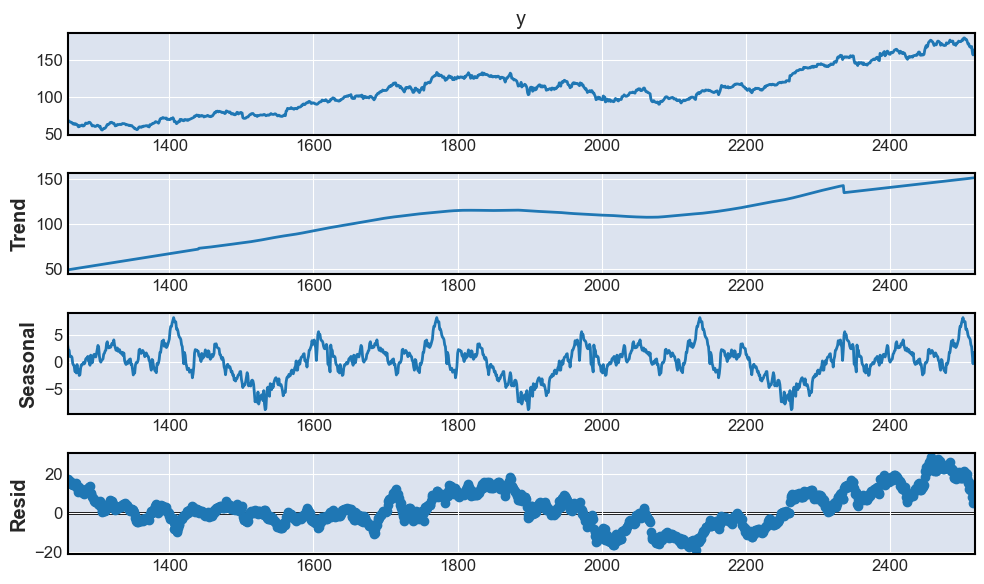

In [52]:
# let's find compoenets for aapl stock price
tr, se, re = decomposition(aplph_df, 365)

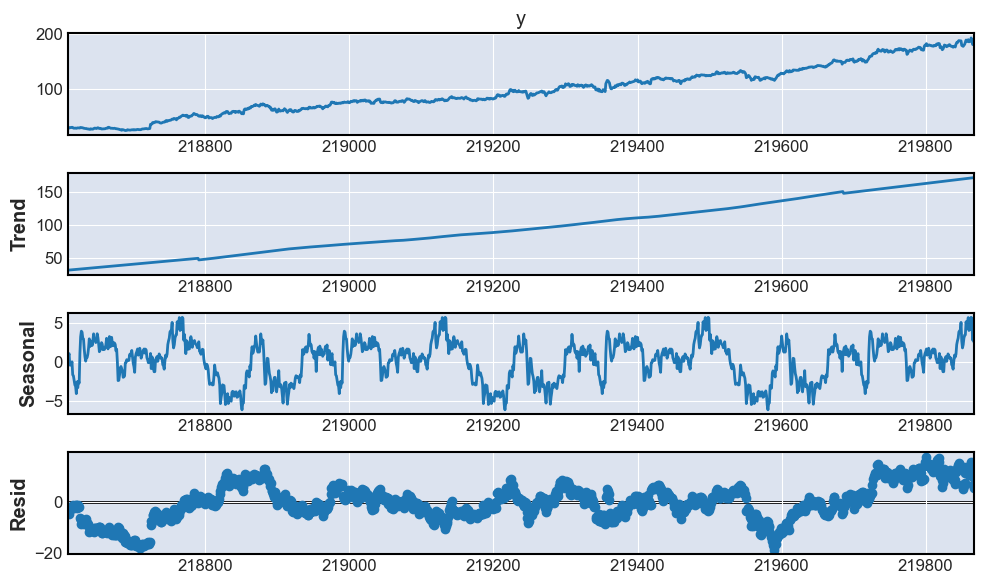

In [53]:
# let's find out components for fb stock price
ftr, fse, fre = decomposition(fbph_df, 365)

### Plot the autocorrelation and partial auto-correlation plots

In [54]:
# function to retunr acf and pacf plots
def acf_pacf(df, lags):
    var = df['y']
    # plot the acf plot
    fig = plot_acf(var, lags=lags)
    fig.set_size_inches((9, 5))
    fig.tight_layout()
    plt.show()
    
    # plot the pacf plots
    fig = plot_pacf(var, lags=lags)
    fig.set_size_inches((9,5))
    fig.tight_layout()
    plt.show()

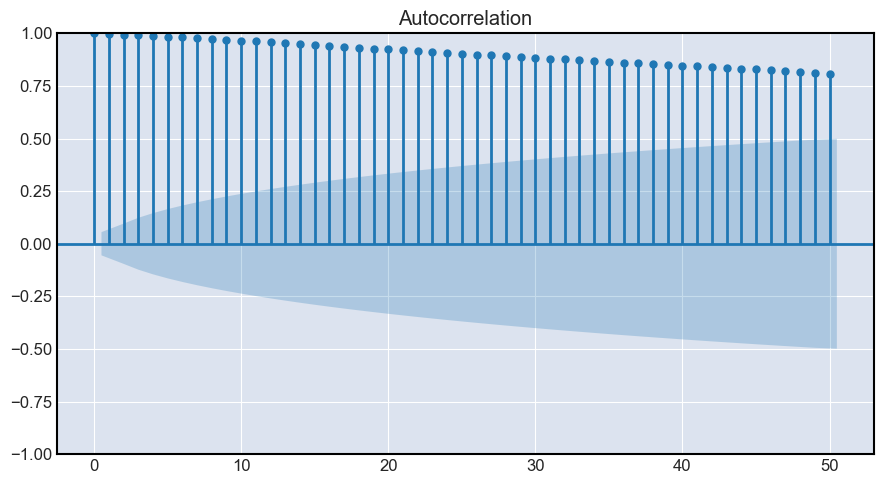

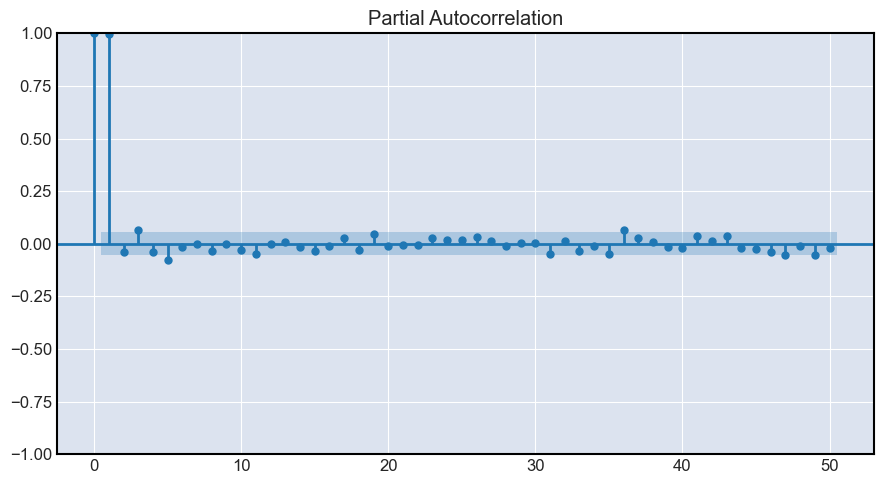

In [55]:
# acf and pacf of aapl stock 
acf_pacf(aplph_df, 50)

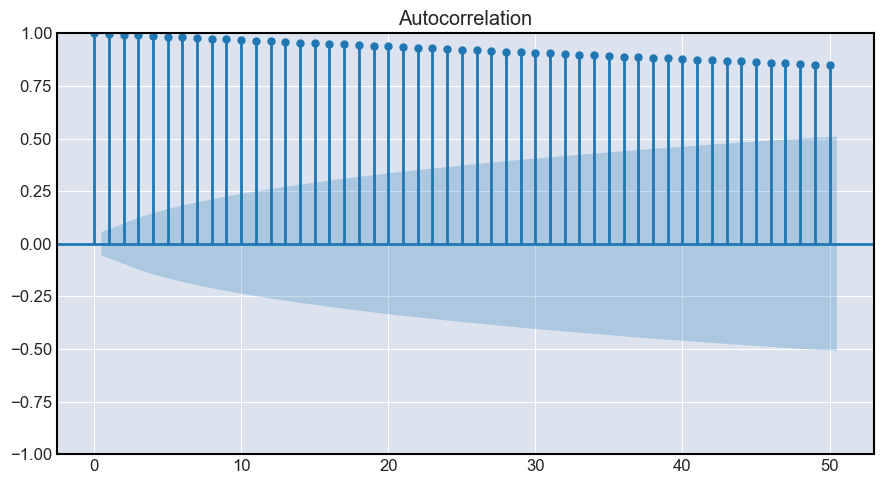

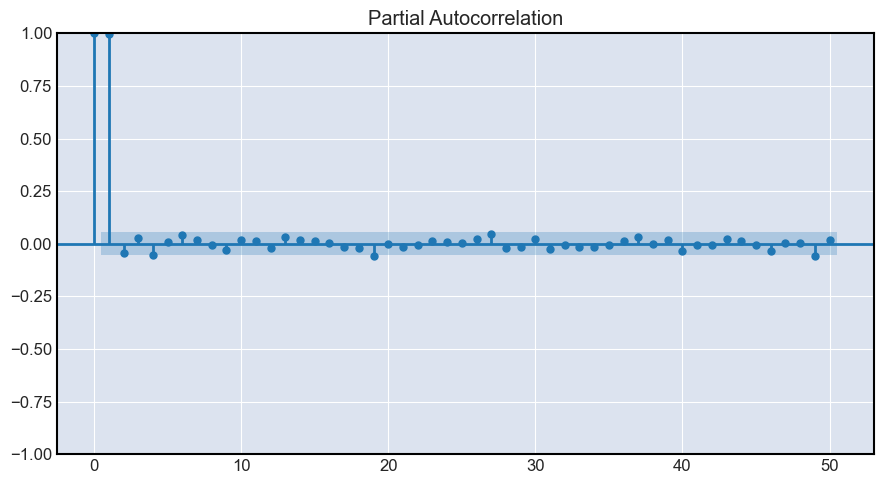

In [56]:
# acf and pacf plots of FB
acf_pacf(fbph_df, 50)

### Auto-correlation Interpretation

A slow decline in auto-correlation indicates that the time series is not stationary. We can confirm the stationarity of the time series using the Dickey-Fuller test.

### Partial Auto-correlation Interpretation

For both stocks, PACF suggests that time-series dependence can be captured by only one lag, as it shows significance compared to other lagged time-series.


## Dickey-Fuller Test (Stationarity Test)

### Hypotheses for Dickey-Fuller Test

- **H0 (Null Hypothesis):** Beta = 1 (the time series is non-stationary).
- **HA (Alternative Hypothesis):** Beta < 1 (the time series is stationary).


In [57]:
# funtion to return adfuller test results
def adfuller_test(df):
    adfuller_result = adfuller(df['y'], autolag='AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index=['Test statistic', 'p-value',
                                                           'Lags Used','Number of Observations Used'])
    print(adfuller_output)

In [58]:
print("adfuller test results for AAPLE")
adfuller_test(aplph_df)
print("----"*10)
print("adfuller test results for FB")
adfuller_test(fbph_df)

adfuller test results for AAPLE
Test statistic                   -0.665091
p-value                           0.855586
Lags Used                         0.000000
Number of Observations Used    1258.000000
dtype: float64
----------------------------------------
adfuller test results for FB
Test statistic                    0.177529
p-value                           0.970973
Lags Used                         8.000000
Number of Observations Used    1250.000000
dtype: float64


- Both the stocks time-series is not stationary as p-values are much greater than 0.05, hence we cannot reject the null-hypothesis.

### Finding degree of differencing

In [59]:
# find degree of differencing 
def degree_of_differencing(df, co_name):
    company_ndiffs = ndiffs(df['y'], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {co_name}')
    
    return company_ndiffs

aapl_ddf = degree_of_differencing(aplph_df, 'APPLE')
fb_ddf = degree_of_differencing(fbph_df, 'Facebook')

The degree of differencing is 1 for APPLE
The degree of differencing is 1 for Facebook


### Train Forecasting Models using Auto-ARIMA

ARIMA stands for Auto Regressive Integrated Moving Average. The model's goal is to predict future securities or financial market moves by examining the differences between values in the series instead of through the actual values. An ARIMA model can be understood by outlining each of its components as follows:

- **Auto Regression (AR):** Refers to a model that shows a changing variable that regresses on its own lagged or prior values.
  
- **Integrated (I):** Represents the differencing of raw observations to allow for the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).
  
- **Moving Average (MA):** Incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.


In [60]:
# funcrtion to split train and test time-series for modelling purpose
def arima_split(df, co_name):
    size = int(len(df)*0.95)
    train_df = (df['y'])[:size]
    test_df = (df['y'])[size:]
    
    print(f"data splits of company {co_name}")
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")
    print("-------------------------------")
    
    return train_df, test_df

apl_train, apl_test = arima_split(aplph_df, 'APPLE')
fb_train, fb_test = arima_split(fbph_df, 'FB')

data splits of company APPLE
Train Size: 1196, Test Size: 63
-------------------------------
data splits of company FB
Train Size: 1196, Test Size: 63
-------------------------------


In [61]:
def find_best_fit_arima(df, co_name):
    print(f"Arima model for {co_name}")

    model = pm.auto_arima(df, test = 'adf', 
                          start_p = 1, start_q = 1,     
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,   
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',  
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')
    
    return model

model_apl = find_best_fit_arima(apl_train, 'APPLE')
model_fb = find_best_fit_arima(fb_train, 'FB')

Arima model for APPLE
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=38.94 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=5737.373, Time=0.96 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=4795.557, Time=2.15 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=5191.240, Time=1.12 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=5746.692, Time=0.68 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=5067.196, Time=0.55 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=4657.095, Time=2.95 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=10.25 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=5.69 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=5740.397, Time=1.80 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=4647.664, Time=3.11 sec
 ARIMA(2,0,0)(1,1,0)[3] intercept   : AIC=4777.434, Time=1.35 sec
 ARIMA(2,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=8.21 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=4.14 sec
 ARIMA(2,0,1)(2,1,0)[3] intercept 

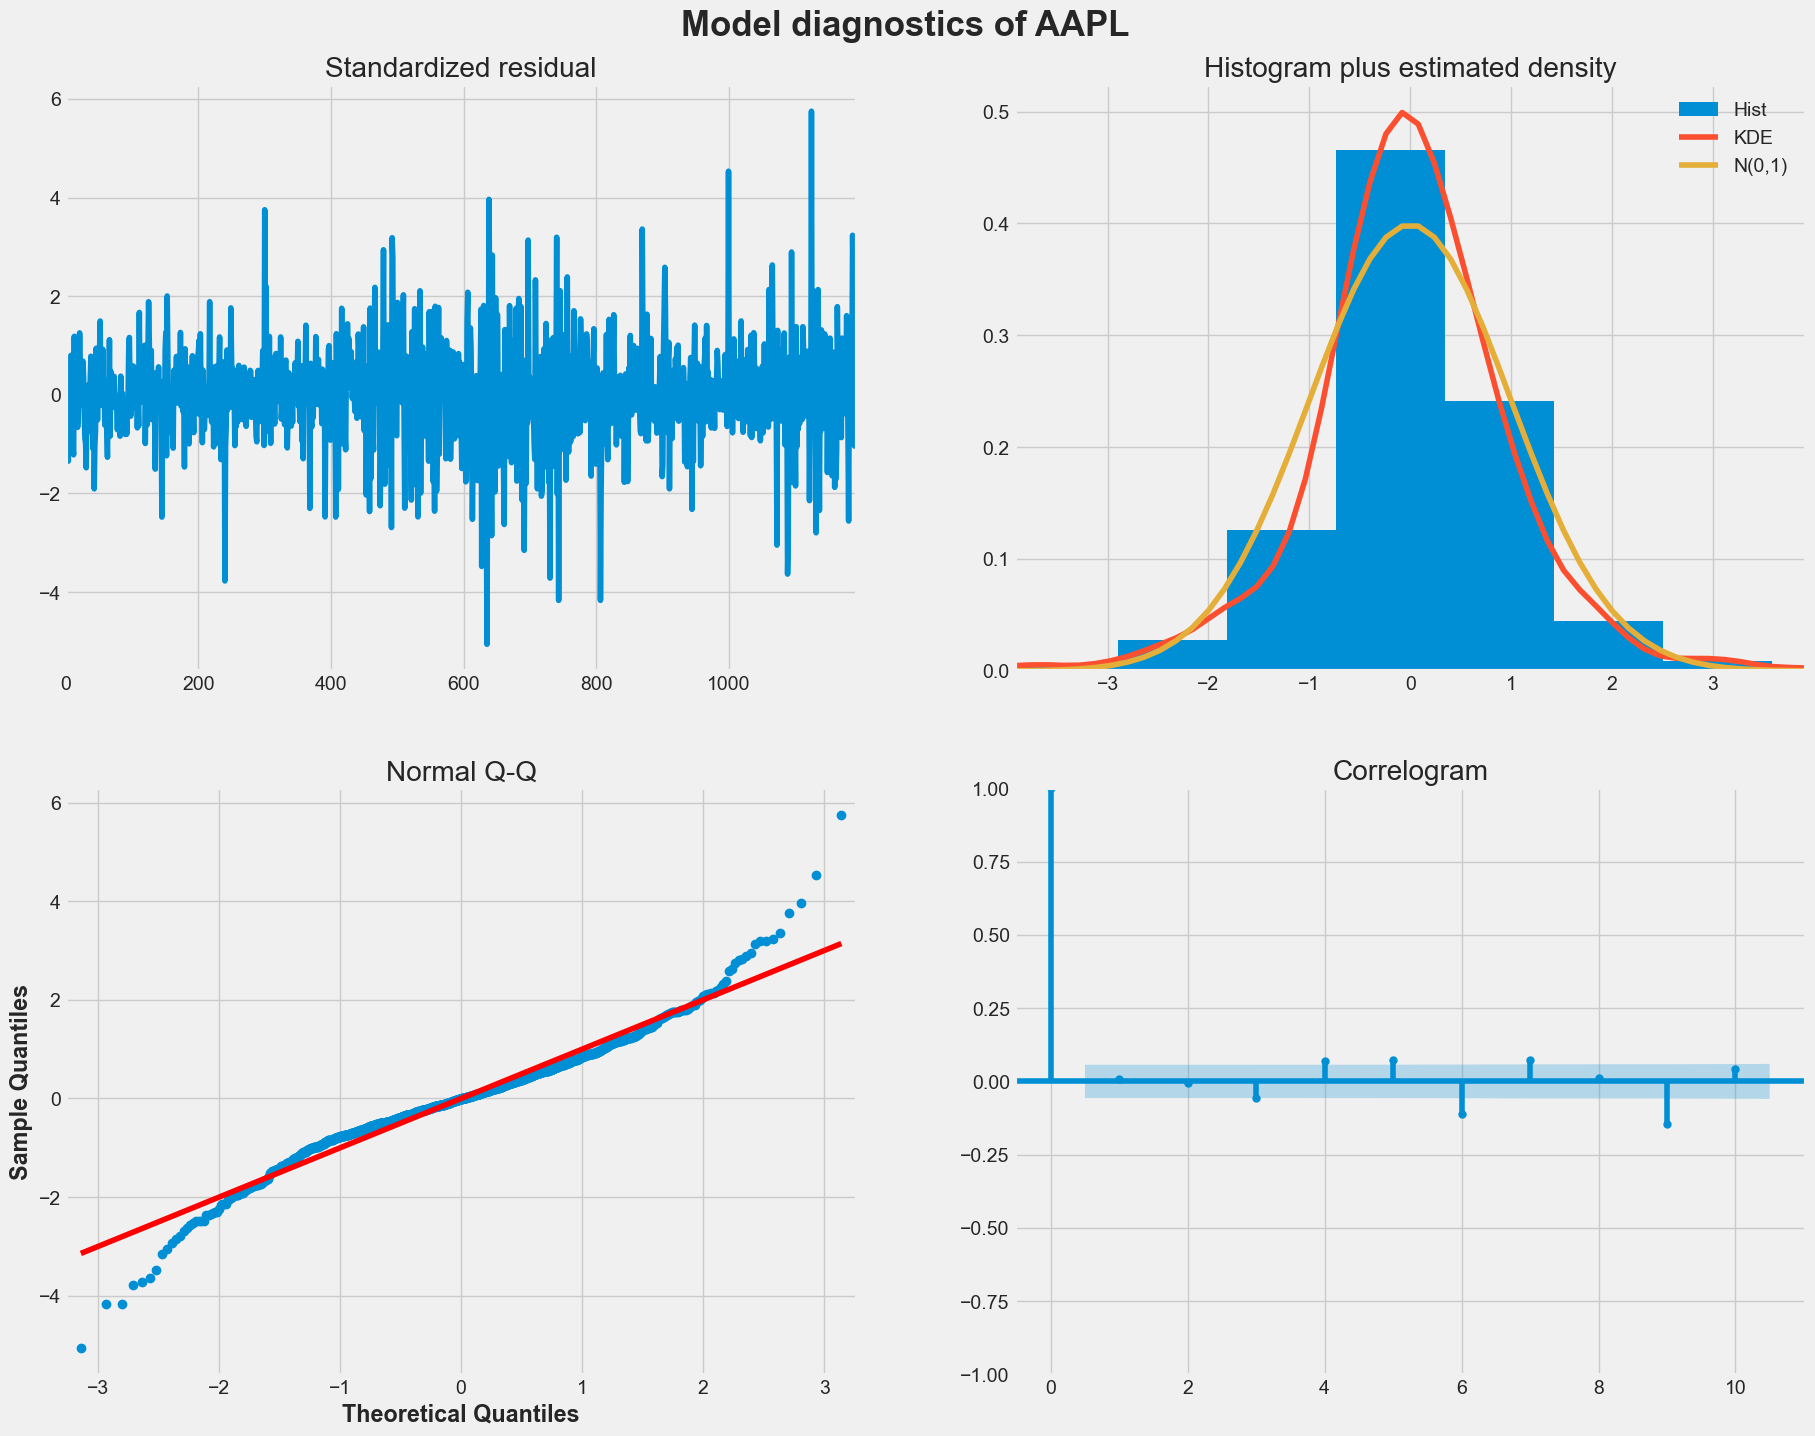

--------------------------------------------------------------------------------------------------------------------------------------------


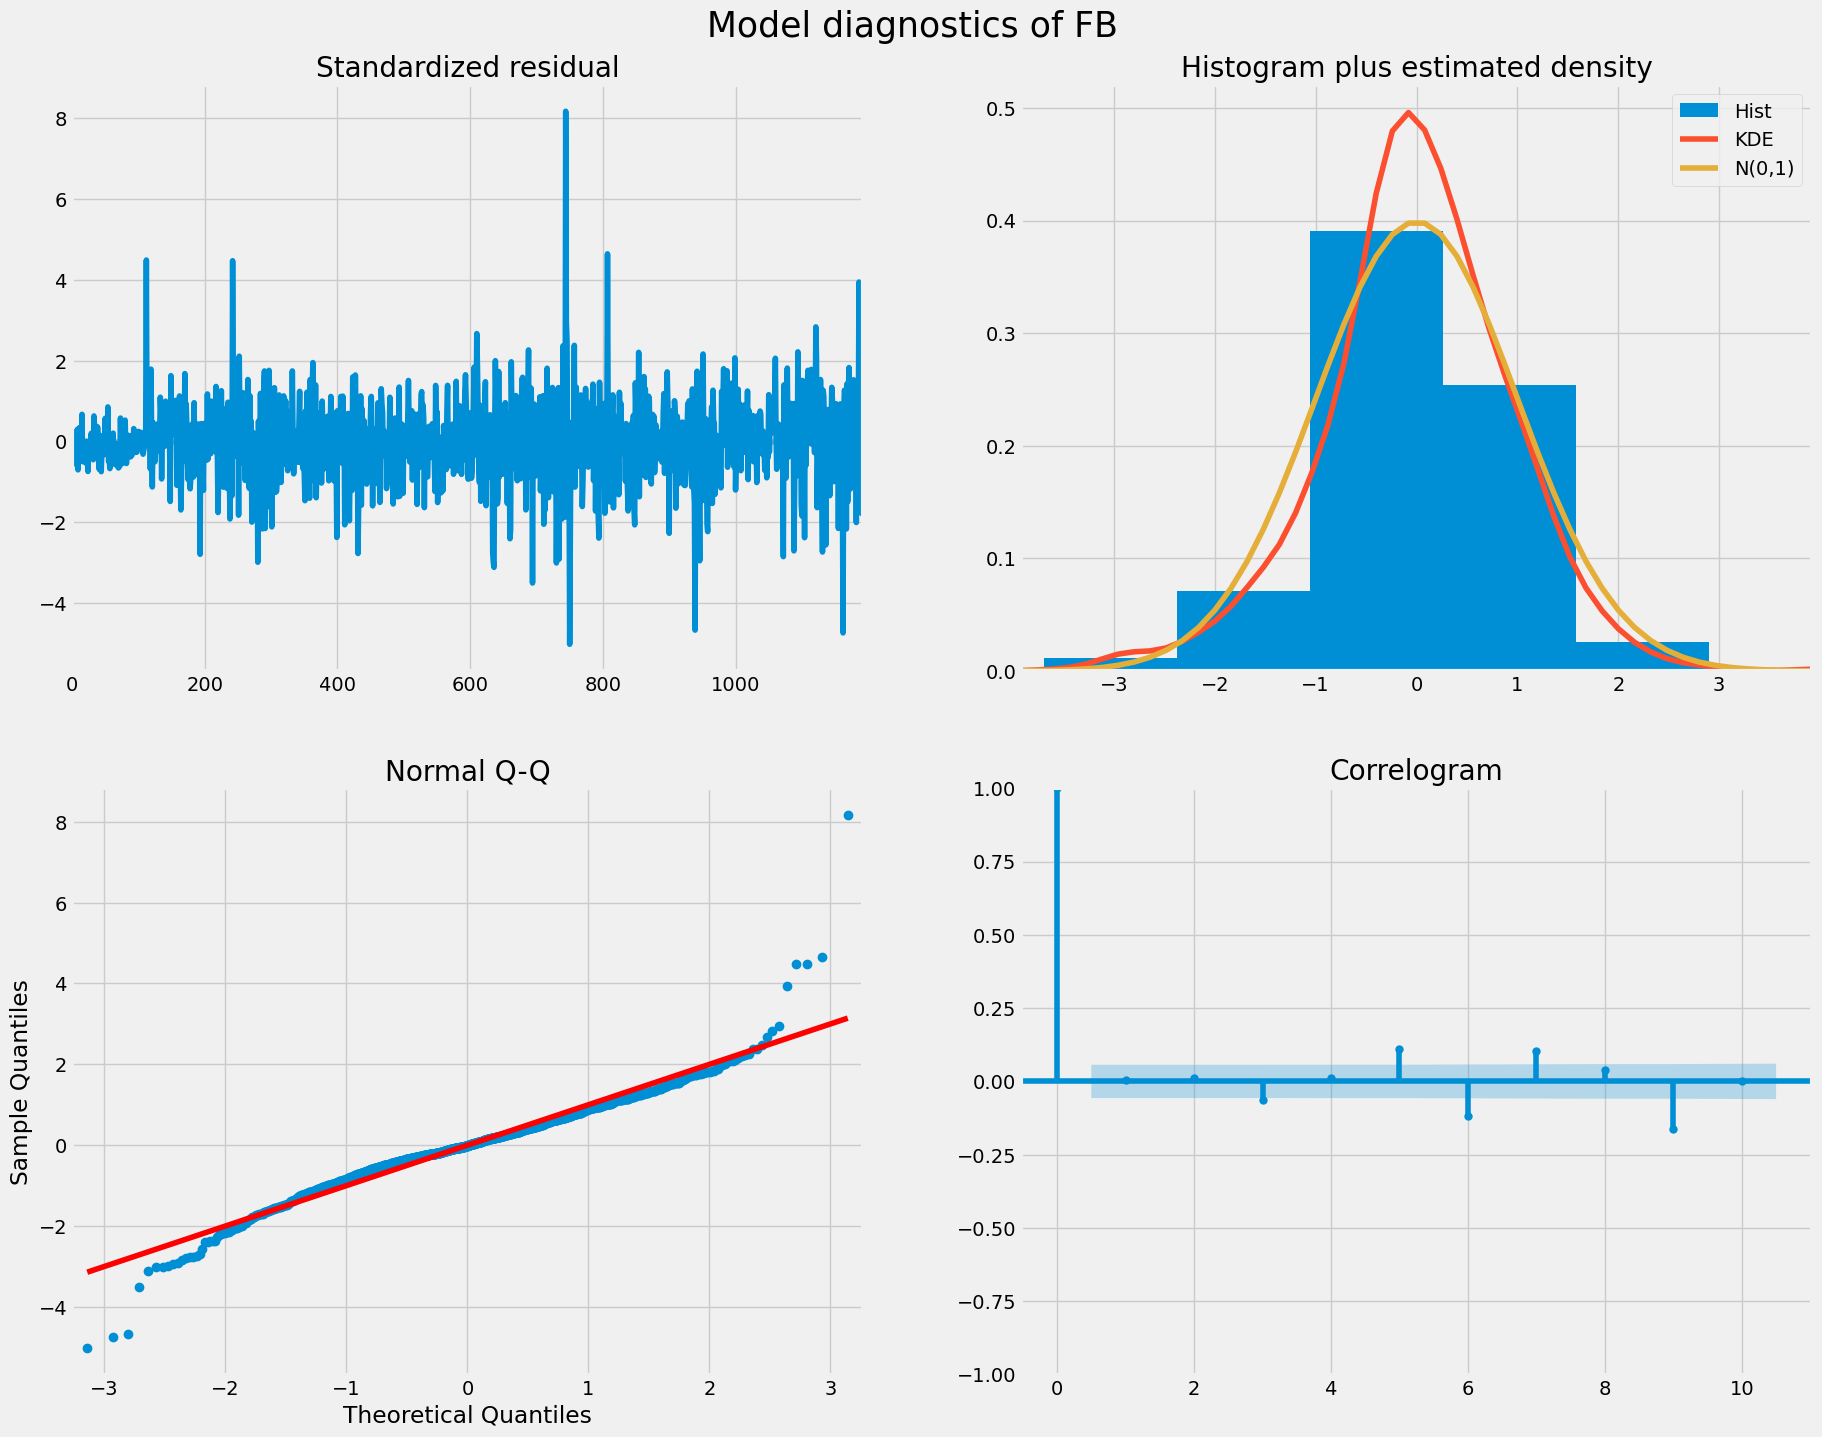

In [62]:
# let's plot forecasting models plots
def display_model_plots(model, co_name):
    plt.style.use('fivethirtyeight')
    model.plot_diagnostics(figsize = (20, 15));
    plt.suptitle(f'Model diagnostics of {co_name}', fontsize = 25)
    plt.subplots_adjust(top = 0.93)
    plt.show()
    plt.style.use('default')
    
display_model_plots(model_apl, 'AAPL')
print("-------"*20)
display_model_plots(model_fb, 'FB')

### Model diagnostics interpretation:

1) Standardized residual: It is an error term of price forecating and actual price of stocks

2) Histogram plus estimated density: Histogram reresents normal distribution of errors, KDE plots and N(0,1) is notation of indicate mean is ZERO and variance of the distribution is ONE.

3) Normal Q-Q: Normal Q-Q plot implies normality of distribution as sample quantities mostly inline with theoretical quanitites. any deviation in such alignment would indicate distribution is skewed, or in layman terms error is either positive or negative side.

4) Correlogram: It simply indicates partial auto-correlation of time-series and shows which laged time-series is significant in forecasting actual time-series.

### Forecasting on test data and calculating RMSE

In [63]:
def make_predictions_and_print_rmse(model, test_df, co_name):
    print(f"forecasting and RMSE of {co_name}")
    
    forecast, confidence_interval = model.predict(X=test_df, n_periods = len(test_df), return_conf_int = True)
    forecasts = pd.Series(forecast, index = test_df[:len(test_df)].index)
    lower = pd.Series(confidence_interval[:, 0], index = test_df[:len(test_df)].index)
    upper = pd.Series(confidence_interval[:, 1], index = test_df[:len(test_df)].index)
    
    rmse = np.sqrt(np.mean((forecast.values - test_df.values) ** 2))
    
    print("RMSE is: ", rmse)
    
    return forecasts, lower, upper

forecast, lower, upper = make_predictions_and_print_rmse(model_apl, apl_test, 'APPLE')
print("----------------------------")
forecastf, lowerf, upperf = make_predictions_and_print_rmse(model_fb, fb_test, 'FB')

forecasting and RMSE of APPLE
RMSE is:  7.302896448296766
----------------------------
forecasting and RMSE of FB
RMSE is:  4.205905934671577


<div style="background-color: #4bd659; color: white; padding: 5px;">
    <h1>Conclusion</h1>
</div>

1. In this notebook, we learned saw detailed analysis of time-series to find insights and findout best stocks among all the stocks

2. We visualized stock prices and proved hypothesis of daily return of stocks

3. Finally, we built a forecasting models usgin  'Auto-ARIMA' models to forecast future values of time-series

4. We found noth time-series being non-stationary and their degrees of differencing were 1